# Workspace Setup

## Import Libraries

In [2]:
import copy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patheffects as pe
from scipy.interpolate import interp1d
from simulation import mig_rowseries
from scipy.stats import gaussian_kde

%matplotlib inline
# control default pyplot parameters
plt.style.use('default')
plt.rc('figure', figsize=(6, 5))
plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=18) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=12, frameon=False) #fontsize of the legend
plt.rc('lines', linewidth=5, markeredgewidth=3)  # line format
mpl.rcParams['font.family'] = 'Liberation Sans'  # font style
plt.rcParams['svg.fonttype'] = 'none'

# global constants
color_list = mpl.colormaps['tab10']([1, 0])
color_list_dark = np.array([mpl.colormaps['Oranges'](0.65), mpl.colormaps['Blues'](0.65)])
threshold = 0.5  # invader fraction threshold for calculating invasion speed
fig_path = './figs_python/'

## Define Functions

### Plotting

In [3]:
def draw_wave(series, day_list=None, fig=None, line_color=mpl.colormaps['Oranges'](0.65), cbar=True):
    """
    Draw invasion waves in space (x-axis) and time (color).
    
    Parameters:
    - series (array-like): 2-D array of invader fraction to plot. nday * nwell.
    - day_list (array-like, optional): Array of day numbers corresponding to the invader fraction. Defaults to range(nday).
    - fig (matplotlib.figure.Figure, optional): The figure object to plot on. If None, a new figure is created.
    - line_color (str, optional): The color of the lines in the plot, corresponding to day_list. Defaults to the orange colormap.
    - cbar (bool, optional): Whether to create a colorbar for the plot. Defaults to True.
    
    Returns:
    matplotlib.colorbar.Colorbar: The colorbar object if cbar is True, None otherwise.
    """
    nday = series.shape[0]
    if day_list is None:
        day_list = range(nday)
    else:
        if len(day_list) != nday:
            raise(ValueError, "`nday` doesn't match, `series` has {} days while `day_list` has {}".format(nday, len(day_list)))

    # 2D migrations
    if fig is None:
        fig = plt.figure(figsize=[4.8, 3], dpi=300)
    else:
        fig = plt.gcf()
    ax = plt.gca()
    # loop over days to plot spatial distribution of invader (fraction)
    for iday in range(nday):
        day = day_list[iday]
        plt.plot(range(series.shape[1]), series[iday, :], '.-', label='day{}'.format(day),
                lw=3, mew=2, color=line_color, alpha=max(0.1, iday / nday))
    plt.xlabel('Well position $x$')
    plt.ylabel('Invader fraction $f$')
    # plt.legend()

    # create a color map
    col_arr = np.zeros((nday, 4))
    col_arr[:, :3] = line_color[:-1]  # remove alpha
    alphas = np.arange(nday) / nday
    alphas[alphas < 0.1] = 0.1
    col_arr[:, -1] = alphas
    cmap = cm.ScalarMappable(norm=mpl.colors.Normalize(0, nday), cmap=mpl.colors.ListedColormap(col_arr))

    # create a colorbar
    if cbar:
        axins = ax.inset_axes([1.05, 0, 0.05, 1])
        hcbar = fig.colorbar(cmap, cax=axins, label='Time $n$ (day)')
        plt.sca(ax)
        return hcbar
        

def draw_wave_speeds(wave_speeds, time_points=None, ax=None, 
                     exclude_from_mean=1, vmax=1, vmin=0, datamax=1.5, datamin=-0.5, cbar=False):
    """
    Draws wave speed data on a given axis, with options to adjust the visualization.

    Parameters:
    - wave_speeds (array-like): 1-D Array of wave speeds to plot.
    - time_points (array-like, optional): Array of time points corresponding to the wave speeds. Defaults to a range starting from 1.
    - ax (matplotlib.axes.Axes, optional): The axis to plot on. If None, a new figure is created.
    - exclude_from_mean (int, optional): Index from which to start calculating the mean for color mapping. Defaults to 1.
    - vmax (float, optional): The maximum value for normalizing the colormap. Defaults to 1.
    - vmin (float, optional): The minimum value for normalizing the colormap. Defaults to 0.
    - datamax (float, optional): The maximum y-axis limit for the plot. Defaults to 1.5.
    - datamin (float, optional): The minimum y-axis limit for the plot. Defaults to -0.5.

    Returns:
    matplotlib.colorbar.Colorbar: The colorbar object if cbar is True, None otherwise.
    """
    if ax is None:
        fig = plt.figure(figsize=[4.8, 3])
        ax = plt.gca()
    if time_points is None:
        time_points = np.arange(len(wave_speeds)) + 1
    
    datamean = np.nanmean(wave_speeds[exclude_from_mean:])
    
    # Get the colormap
    cmap = mpl.colormaps['Oranges']
    # Normalize the value based on vmin and vmax
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    # Get the color from the colormap
    facecolor = cmap(norm(datamean))
    # Set the face color of the axis
    ax.set_facecolor(facecolor)
    # Set the stroke color (as patch color) and line color (as patch edge color)
    linecolor = [0.2, 0.2, 0.2]
    strokecolor = 'white'

    # Overlay the raw time series
    ax.plot(time_points, wave_speeds,
            color=linecolor, path_effects=[pe.Stroke(linewidth=8, foreground=strokecolor), pe.Normal()])
    ax.set_ylim([datamax, datamin])
    
    if cbar:
        axins = ax.inset_axes([1.05, 0, 0.05, 1])
        hcbar = plt.gcf().colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=cmap), 
                                   cax=axins, label='Mean invasion speed')
        plt.sca(ax)
        return hcbar


def plot_communities(comm_list=None, comm_compo=None, x_values=None, log_frac=False, norm='log', sp_colors=None, sp_list=None, **kwarg):
    """
    plot a list of community structure as stacked bar plot.
    
    :param comm_list: list, each entry is a dictionary recording composition of one single community (key: species name, value: CFU/5uL)
    :param x_values: list, tag for each community in the list
    :param log_frac: bool, if True log transform colony counting data
    :param kwarg: pass on to matplotlib.pyplot.bar()
    """
    if comm_compo is None:
        assert (comm_list is not None), "comm_list and comm_compo cannot both be None"
        comm_list = np.array(comm_list).flatten()
        ncomm = comm_list.size
        if sp_list is None:
            list(set(np.concatenate([list(comm.keys()) for comm in comm_list])))
        nspe = len(sp_list)
        comm_compo = np.zeros((ncomm, nspe))
        for icomm in range(ncomm):
            comm = comm_list[icomm]
            for ispe in range(nspe):
                sp = sp_list[ispe]
                if sp in comm.keys():
                    comm_compo[icomm, ispe] = comm[sp]
        # comm_compo = np.array([[comm[sp] for sp in sp_list] for comm in comm_list])  # ncomm * nspe
    else:
        ncomm, nspe = comm_compo.shape
    if x_values is None:
        x_values = np.arange(ncomm)+1
    if sp_list is None:
        splist = np.arange(nspe)
    if sp_colors is None:
        sp_colors = [mpl.cm.tab10(i % 10) for i in range(nspe)]
    
    ax = plt.gca()
    
    if log_frac:
        data = np.log10(comm_compo + 1)
    else:
        if norm == 'log':
            data = comm_compo / np.sum(comm_compo, axis=1).reshape((ncomm,1)) * np.log10(np.sum(comm_compo, axis=1).reshape((ncomm,1)) + 1)
        elif norm == 'linear':
            data = comm_compo / np.sum(comm_compo, axis=1).reshape((ncomm,1))
        else:
            data = comm_compo
        
    data[np.isnan(data)] = 0
    
    curr_bottom = np.zeros((ncomm,))  # record current bar bottom position for stacked bar plot
    for isp,sp in enumerate(sp_list):
#         data = np.log10(comm_compo[:,isp]+1)
        data_1s = data[:,isp]
        ax.bar(x_values, data_1s, bottom=curr_bottom, label=sp, color=sp_colors[isp], **kwarg)
        curr_bottom += data_1s.flatten()

### Reading data files

In [4]:
 def read_od_series(file, withtemp=True, combt=False, pltshape=[8,12]):
    """
    example usage:
    >>> dfs, tps = read_od_series('./path/filename.csv')

    :param file: path+file name
    :param withtemp: True if temperature is recorded
    :param combt: True if combine reads at different time points, return a 8*12 np.array with each entry a time series
    :param pltshape: [nrow, ncol] of the plate being read
    :return:
        if combt is True:
            trajarr: a 3D np.array, each layer is OD of one time point
            timepoints: a list of time points for taking OD reads, time unit is hour
        if combt is False
            dfseries: a list of pandas.Dataframe, each contain OD of one time point
            timepoints: a list of time points for taking OD reads, time unit is hour
    """
    dfseries = []
    df_firstcol = pd.read_csv(file, encoding="iso-8859-1", header=None, usecols=[0], skip_blank_lines=False)
    df_timetags = df_firstcol[df_firstcol.iloc[:, 0].str.startswith('Time [s]:').fillna(False)]
    timepoints = [int(df_timetags.iat[k, 0].replace('Time [s]: ', '')) / 3600 for k in range(len(df_timetags))]
    ntp = len(timepoints)

    nrow, ncol = pltshape

    for j in range(ntp):
        dfseries.append(pd.read_csv(file, encoding="iso-8859-1", skiprows=df_timetags.index[j]+1+withtemp, header=0,
                                    names=range(1, ncol+1), skip_blank_lines=False, nrows=nrow, index_col=0).astype('float64'))
    if combt:
        trajarr = np.zeros((nrow, ncol, ntp))
        for row in range(nrow):
            for col in range(ncol):
                trajarr[row, col, :] = np.array([dfseries[i].iloc[row, col] for i in range(len(timepoints))])
        return trajarr, timepoints
    else:
        return dfseries, timepoints
    
    
def read_od_endpoint(file, withtemp=True, pltshape=[8,12]):
    df_od = read_od_series(file, withtemp=withtemp, combt=False, pltshape=pltshape)[0][0]
    return df_od

### Calculations

In [5]:
def cfu_str2dict(s, sp_list=[]):
    """
    Given a string of manual cfu counts, return a dictionary of CFU per species
    
    Examples:
    Input: 'sp1-10e3 sp2-4e5'
    Return: {'sp1': 10e3, 'sp2': 4e5}
    
    If sp_list is given, initialize the given species with 0 CFU.
    """
    
    cfu_dict = dict.fromkeys(sp_list)
    cfu_str_list = s.split()
    for cfu_str in cfu_str_list:
        sp, cfu = cfu_str.split('-')
        cfu = int(float(cfu))
        cfu_dict[sp] = cfu
    
    return cfu_dict


def pos_above_thre(distr, f_thre, pos=None):
    """
    Position of invader fraction first above threshold for multiple distributions
    Interpolate between two adjacent positions to get a continuous position

    :param distr: np.array of shape (n_mig, n_day, n_well), fraction of invader
    :param f_thre: threshold for measuring invasion speed
    :param pos: np.array of shape (n_well), position of wells
    :return: np.array of shape (n_mig, n_day), position of invader fraction first above threshold
    """
    if len(distr.shape) == 1:
        distr = distr.reshape(1, -1)

    if pos is None:
        pos = np.arange(1, distr.shape[1] + 1)

    distr_reversed = np.flip(distr, axis=1)
    idxs = distr.shape[1] - 1 - np.argmax(distr_reversed > f_thre,
                                          axis=1)  # the last well position idx that's above threshold
    mask = np.max(distr > f_thre, axis=1)

    x_0 = pos[idxs]
    x_1 = np.roll(pos, -1)[idxs]

    f_0 = np.take_along_axis(distr, idxs[:, None], axis=1).flatten()
    f_1 = np.take_along_axis(np.roll(distr, -1, axis=1), idxs[:, None], axis=1).flatten()

    x = np.where(mask, (f_0 - f_thre) / (f_0 - f_1) * (x_1 - x_0) + x_0, np.nan)
    x[idxs == distr.shape[1] - 1] = np.nan

    return x


def get_rawdata_arr(file, sheet_name):
    """
    Read raw invasion experiment data.
    For a given sheet in combined raw data excel (e.g. SL_inv_OD.xlsx), read rawdata and return as nday*nrow*ncol array.
    
    :param file: str, path to the excel file
    :param sheet_name: str, name of the sheet to read
    :return: np.array of shape (nday, nrow, ncol), raw data
    """
    # Initialize variables
    data_blocks = []
    day_list = []

    # Iterate over the DataFrame in chunks of 9 rows at a time
    df_sn = pd.read_excel(file, sheet_name, header=None)
    first_row = (df_sn.iloc[:, 0].str.match(r'Day \d+') & ~df_sn.iloc[:, 0].isna()).idxmax()
    # print(f"first row with data: {first_row}")
    for i in range(first_row, len(df_sn), 9):
        # Extract the day number from the first row of each block
        day = df_sn.iloc[i, 0]

        # Check if the day value is a string and follows the expected format
        if isinstance(day, str) and day.startswith("Day"):
            day_number = int(day.split(" ")[1])  # get the number after "Day"
            day_list.append(day_number)

            # Extract the data from the remaining rows of the block
            data_block = df_sn.iloc[i+1:i+9, :]
            data_blocks.append(data_block.values)
        else:
            print(f"Unexpected value in row {i}: {day}")

    # Convert the list of data blocks to a 3D numpy array
    return np.array(data_blocks).astype('float64'), np.array(day_list)  # nday * 8 rows * 12 cols


def remove_scatter(data_raw, s_d=0.08730987, s_u=0.02029704, s_r=0.05823732, s_l=0.03478871, bg=20):
    """
    remove scattered light (i.e., signal crosstalk) from bioluminescence readout. 
    parameters calibrated for the black lumox plates
    
    :param x: raw luciferin readout, layout in the shape of the plate
    :param bg: background, i.e. luciferin readout for blank control wells
    """
    x = data_raw - bg
    data = x * 1  # make a deep copy
    
    data[:-1] -= s_d * (x[1:])  # scattering from lower well
    data[1:] -= s_u * (x[:-1])  # scattering from up
    data[:, :-1] -= s_r * (x[:, 1:])  # scattering from right
    data[:, 1:] -= s_l * (x[:, :-1])  # scattering from left
    data += bg
    
    return data.astype('int32')


def calc_inv_speed(series_allm, f_thre):
    """
    Calculate invasion speed for multiple distributions

    :param series_allm: np.array of shape (n_mig, n_day, n_well), fraction of invader
    :param f_thre: threshold for measuring invasion speed
    :return vn_allm: np.array of shape (n_mig, n_day), daily invasion speed
    """
    # if series_allm just has one migration rate, reshape it to make it 3D
    if len(series_allm.shape) == 2:
        series_allm = series_allm.reshape(1, *series_allm.shape)
    vn_allm = np.zeros(series_allm.shape[:2])
    vn_allm[:, :] = np.nan
    for im in range(series_allm.shape[0]):
        series = series_allm[im, :]
        pos = pos_above_thre(series, f_thre)
        vn = pos[1:] - pos[:-1]
        vn_allm[im, 1:] = vn
    return vn_allm

### Simulation

In [6]:
def sim_waves(func, m_list, nday=40, nwells=[50, 50]):
    """
    if insta==True, also return the max and min of instantaneous speeds after day 10.
    """
    series_allm = np.zeros((len(m_list), nday, sum(nwells)))
    for im, m in enumerate(m_list):
        series = np.array(mig_rowseries(g=func, m=m, day=nday, well=nwells, draw=False))  # nday * sum(nwells)
        series_allm[im, :, :] = series
            
    return series_allm

def mig_rowseries(g, m, day=10, well=[6, 6], distr_ini = None,
                  draw=False, inioutput=False):
    """
    Generate a time series of modeled migration scheme, each entry is a list of species composition (range [0, 1],
    0 for Lp, 1 for Su) of each well at the corresponding time
    :param g: function handle f=g(f0), where f is the final fraction of Su after 1d culture, and f0 is the initial
    fraction of Su
    :param m: migration rate
    :param day: number of days to simulate
    :param well: a listlike of length 2, the starting number of wells for [Su, Lp]
    :param draw: if True directly make the wave propagation plot for single well
    :param inioutput: if True also return iniseries, which records initial communities at start of each day
    :return finalseries: a list timeseries, each entry is a np.array representing the species composition of wells
    (corresponding to a row in experiment) of the timepoint
    :return iniseries: a list of timeseries, each entry is a list of dictionaries {"dilu", "left", "right"}
    dilu: initial community from dilution leftover of old well
    left: initial community from migration from the left well
    right: initial community from migration from the right well
    """
    finalseries = []
    iniseries = []
    # initial species distribution
    if distr_ini:
        distr = distr_ini
    else:
        distr = np.array([1] * well[0] + [0] * well[1])

    for d in range(day):
        finalseries.append(distr)

        ini_dilu = distr * (1-m)  # initial community from dilution leftover of old well
        ini_left = np.concatenate(([0], distr[:-1])) * m/2  # initial community from migration from the left well
        ini_right = np.concatenate((distr[1:], [0])) * m/2  # initial community from migration from the right well
        # add together and rescale border wells
        ini_distr = (ini_dilu + ini_left + ini_right) / np.concatenate(([1-m/2], [1] * (sum(well) - 2), [1-m/2]))
        ini_distr = np.array([round(z, 15) for z in ini_distr])  # discard the last two digit (not precise) of float64
        if inioutput:
            iniseries.append({"dilu":ini_dilu, "left":ini_left, "right":ini_right})

        distr = g(ini_distr)  # final community after growth (modelled as fraction change of species composition)

    if draw:
        colors = np.linspace(1, 0, day)
        for d in range(day):
            plt.plot(range(1, sum(well)+1), finalseries[d], color=colors[d] * np.array([1, 1, 1]))

    if inioutput:
        return finalseries, iniseries
    else:
        return finalseries

## Load Data

Constants
* trm_list_2s
* rep_list_dict_2s: dict of list, key=trm_list_2s
* m_list_dict_2s: dict of list, key=trm_list_2s
* trm_list_ms
* trm_idx_dict_ms
* rep_list_dict_ms
* m_list_dict_ms 

Data
* od_arr_dict_2s: dict of list of array,  nrep * (nday * nmig * nwell)
* day_list_dict_2s: dict of list
* day_list_dict_ms
* luc_arr_dict_ms


### Two-strain system

In [6]:
# define variables
trm_list_2s = ['10mM', '40mM', '60mM', '80mM']
rep_list_dict_2s = {'10mM': ['exp20230207', 'exp20230511', 'exp20220615'],
                    '40mM': ['exp20230207', 'exp20230511', 'exp20220615', 'exp20230612', 'new_m_exp20230612'],
                    '60mM': ['exp20230207', 'exp20230511', 'exp20230612', 'techrep_exp20230612'],
                    '80mM': ['exp20230207', 'exp20230511', 'exp20220615']}
m_list_dict_2s = dict.fromkeys(['exp20230207', 'exp20230511', 'exp20220615', 'techrep_exp20230612', 'exp20230612'], 
                           np.array([0.2, 0.8, 2, 3.8, 6, 10, 20, 40]) / 100)
m_list_dict_2s['new_m_exp20230612'] = np.array([0.4, 1.4, 2.8, 4.8, 7.8, 14.6, 29.2, 50]) / 100
od_arr_dict_2s = {}
day0missing_2s = {}
day_list_dict_2s = {}

# load data
for itrm in range(4):
    trm = trm_list_2s[itrm]
    od_arr_allreps = []
    for irep in range(len(rep_list_dict_2s[trm])):
        od_arr, day_list = get_rawdata_arr('SL_inv_OD.xlsx', f'{trm_list_2s[itrm]}_{rep_list_dict_2s[trm][irep]}')
        if day_list[0] == 0:
            day0missing_2s[f'{trm}_{rep_list_dict_2s[trm][irep]}'] = False
        else:
            day0missing_2s[f'{trm}_{rep_list_dict_2s[trm][irep]}'] = True
        od_arr_allreps.append(od_arr)
        day_list_dict_2s[rep_list_dict_2s[trm][irep]] = day_list
    od_arr_dict_2s[trm] = od_arr_allreps

# calculate wavespeeds
od_arr_normed_dict_2s = dict.fromkeys(trm_list_2s)
ws_exp_dict_2s = dict.fromkeys(trm_list_2s)
for itrm in range(4):
    trm = trm_list_2s[itrm]
    nmig = 8
    nrep = len(rep_list_dict_2s[trm])#3
    ws_exp_dict_2s[trm] = np.zeros((nrep, nmig)).astype('object')
    
    od_arr_normed_dict_2s[trm] = []
    for irep in range(nrep):
        od_arr = od_arr_dict_2s[trm][irep]
        # normalize OD data by smallest and biggest 5th well read number
        od_arr_normed = (od_arr - np.nanquantile(od_arr.reshape([od_arr.shape[0], -1]), 5 / 96, axis=1)[:, np.newaxis, np.newaxis]) / (
            np.nanquantile(od_arr.reshape([od_arr.shape[0], -1]), 1 - 5 / 96, axis=1) 
            - np.nanquantile(od_arr.reshape([od_arr.shape[0], -1]), 5 / 96, axis=1))[:, np.newaxis, np.newaxis]
        if day0missing_2s[f'{trm}_{rep_list_dict_2s[trm][irep]}']:
            od_arr_normed = np.concatenate(([[[1] * 4 + [0] * 8] * 8], od_arr_normed), axis=0)
        od_arr_normed_dict_2s[trm].append(od_arr_normed)

        for im in range(nmig):
            pos_thre = pos_above_thre(np.squeeze(od_arr_normed[:, im, :]), threshold)  # (intrapolated) well position that invader population/fraction went below threshold
            wave_speeds = pos_thre[1:] - pos_thre[:-1]  # daily invasion speed
            
            ws_exp_dict_2s[trm][irep, im] = wave_speeds

### Multi-strain system

In [7]:
# load all data
trm_list_ms = ['CommD', 'CommC', 'CommB', 'CommA']
trm_idx_dict_ms = dict(zip(trm_list_ms, 'DCBA'))
rep_list_dict_ms = dict.fromkeys(trm_list_ms, ['exp20230511', 'exp20230829'])
m_list_dict_ms = {'exp20230511': np.array([0.2, 0.8, 2, 3.8, 6, 10, 20, 40]) / 100,
                  'exp20230829': np.array([2, 4, 6, 8, 10, 12, 22, 40]) / 100}
day_list_dict_ms = {}
luc_arr_dict_ms = {}

# load data
for itrm in range(4):
    trm = trm_list_ms[itrm]
    luc_arr_allreps = []
    for irep in range(2):
        luc_arr, day_list = get_rawdata_arr('CM_inv_luc.xlsx', f'{trm_list_ms[itrm]}_{rep_list_dict_ms[trm][irep]}')
        if day_list[0] > 0:
            luc_arr = np.concatenate(([[[1] * 4 + [0] * 8] * 8], luc_arr), axis=0)
        day_list_dict_ms[rep_list_dict_ms[trm][irep]] = day_list
        luc_arr_allreps.append(luc_arr)
    luc_arr_dict_ms[trm] = luc_arr_allreps

# calculate wavespeeds
threshold = 0.5
luc_arr_normed_dict_ms = dict.fromkeys(trm_list_ms)
ws_exp_dict_ms = dict.fromkeys(trm_list_ms)
for itrm in range(4):
    trm = trm_list_ms[itrm]
    nmig = 8
    nrep = 2
    ws_exp_dict_ms[trm] = np.zeros((nrep, nmig)).astype('object')
    
    luc_arr_normed_dict_ms[trm] = []
    for irep in range(nrep):
        luc_arr = luc_arr_dict_ms[trm][irep]
        luc_arr_normed = luc_arr / np.nanquantile(luc_arr, 1 - 2 / 12, axis=2)[:, :, np.newaxis]
        luc_arr_normed_dict_ms[trm].append(luc_arr_normed)

        for im in range(nmig):
            pos_thre = pos_above_thre(np.squeeze(luc_arr_normed[:, im, :]), threshold)  # (intrapolated) well position that invader population/fraction went below threshold
            wave_speeds = pos_thre[1:] - pos_thre[:-1]  # daily invasion speed

            ws_exp_dict_ms[trm][irep, im] = wave_speeds

# Fig - Experimental setup

## Conceptual

### Invasion wave demo (Fig2b)

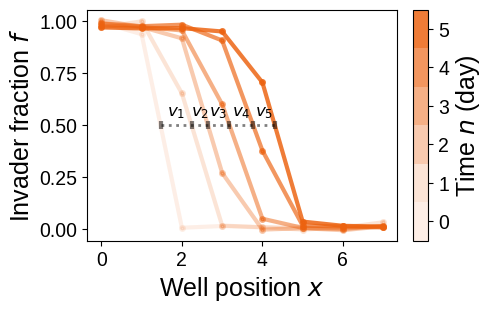

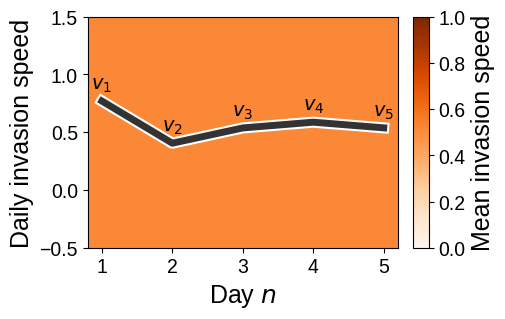

In [28]:
# select example data for illustration
trm = "80mM"  # treatment
irep = 1  # replicate
im = 5  # dispersal rate
series = od_arr_normed_dict_2s[trm][irep][:, im, :]
days = np.arange(6)
series = series[days, 2:-2]  # only show the first 6 days and the middle 8 wells
# series = series / series.max(axis=1)[:, np.newaxis]  # normalize to max 1

thre = copy.deepcopy(threshold)
pos_thre = pos_above_thre(series, thre, np.arange(series.shape[1]))
ws_vn = pos_thre[1:] - pos_thre[:-1]
# plt.plot(pos_thre, np.ones(len(pos_thre)) * thre, 'k.-')

drawdays_idx = [0, 1, 2, 3, 4, 5]
nday = len(days)

## 2D migrations
# waves
fig = plt.figure(figsize=np.array([4, 3]))  # for small illustration, figsize / 2
hcbar = draw_wave(series, fig=fig, cbar=True)
hcbar.set_ticks(np.arange(nday) + 0.5)
hcbar.set_ticklabels(np.arange(nday))

# define v_n on waves
if len(drawdays_idx) > 1:
    plt.plot(pos_thre[drawdays_idx], np.ones(len(drawdays_idx)) * thre, 'k:|', alpha=0.5, lw=2)
    for iday in drawdays_idx[1:]:
        plt.text((pos_thre[iday] + pos_thre[iday - 1]) / 2, thre + 0.02, f'$v_{days[iday]}$', 
                 fontsize=12, ha='center', va='bottom')

## v_n vs. n
# plt.legend()
fig2 = plt.figure(figsize=[4, 3])
draw_wave_speeds(ws_vn, ax=plt.gca(), cbar=True)
plt.ylim([-0.5, 1.5])
# plt.plot([2, nday - 1], np.ones(2) * ws_vn[1:].mean(), 'k--', lw=2, alpha=0.5)
plt.xlabel('Day $n$')
plt.ylabel('Daily invasion speed')

# label v_n on plot
for iday in range(nday)[1:]:
    day = days[iday]
    plt.text(day, ws_vn[iday - 1] + 0.06, f'$v_{days[iday]}$', 
             fontsize=14, ha='center', va='bottom', color='k')

# fig.savefig('conceptual_invwave.svg', bbox_inches="tight")
# fig2.savefig('conceptual_vn.svg', bbox_inches="tight")

### interaction curve and critical dispersal rate (FigS14b)

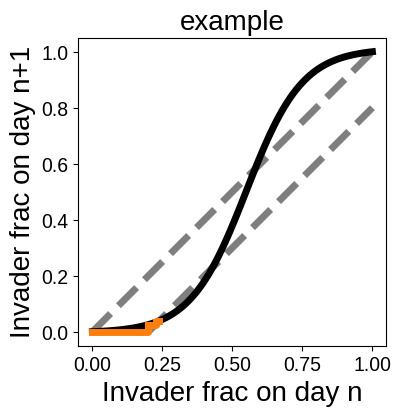

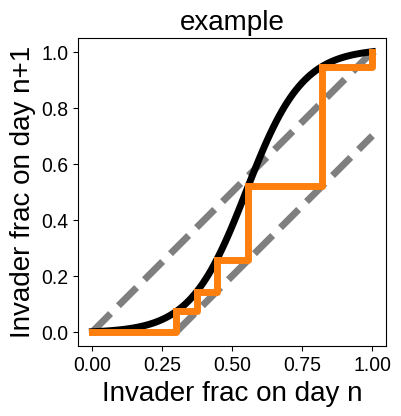

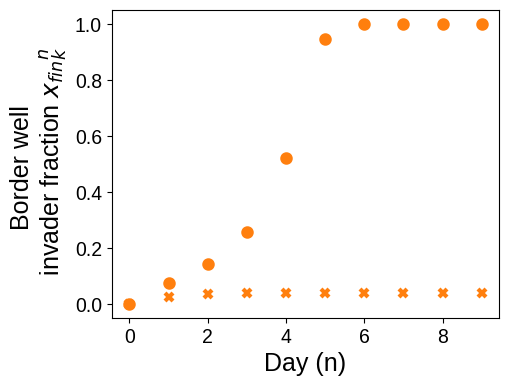

In [29]:
# Sigmoid function definition
def sigmoid(x, a, b):
    y = 1 / (1 + np.exp(-a * (x - b)))
    y_max = 1 / (1 + np.exp(-a * (1 - b)))
    y_min = 1 / (1 + np.exp(-a * (0 - b)))
    return (y - y_min) / (y_max - y_min)

x_data = np.linspace(0, 1, 100)
fun = lambda x: sigmoid(x, 10, 0.55)
y_data = fun(x_data)

# time trajectory
fig2, ax2 = plt.subplots(1, 1, figsize=[5, 4])
plt.xlabel('Day (n)')
plt.ylabel('Border well \n invader fraction ${x_{fin}}^n_k$')

# cobwebbing

for im, m in enumerate([0.2, 0.3]):
    fig, axes = plt.subplots(1, 1, figsize=[5, 4], sharey=True)
    ax = axes
    ax.set_aspect('equal', 'box')
    plt.sca(ax)

    plt.xlabel('Invader frac on day n', fontsize=20)
    plt.ylabel('Invader frac on day n+1', fontsize=20)
    plt.plot(x_data, y_data, 'k-')
    # plt.plot(1 - np.linspace(0, 1, 200), 1 - func(np.linspace(0, 1, 200)), 'k', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title('example')

    plt.plot([0 + m, 1], [0, 1 - m], 'k--', alpha=0.5)

    f_ini = 0
    f_fin = 0
    f_fin_list = []
    for ii in range(10):
        f_fin_list.append(f_fin)
        f_ini_old = copy.deepcopy(f_ini)
        f_fin_old = copy.deepcopy(f_fin)
        f_ini = min(f_fin_old + m, 1)
        f_fin = fun(f_ini)
        plt.plot([f_ini_old, f_ini, f_ini], [f_fin_old, f_fin_old, f_fin], color=color_list[0])

    # fig.savefig(f'example_irf_m{m}.svg')

    plt.sca(ax2)
    if im == 0:
        plt.plot(f_fin_list, 'x', color=color_list[0], label='')
    else:
        plt.plot(f_fin_list, 'o', color=color_list[0], label='')

## Two-strain system
Su: Sporosarcina ureae, Lp: Lactobacillus plantarum


### Lp/Su changes pH (FigS1a)

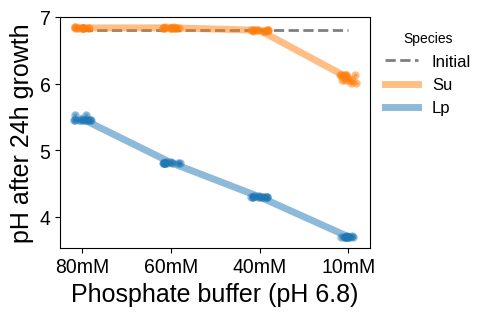

In [30]:
su_fin_pH = np.zeros((2, 4, 6))  # nday * ntrm * nrep
lp_fin_pH = np.zeros((2, 4, 6))  # nday * ntrm * nrep
trm_list = '10mM 40mM 60mM 80mM'.split()

df_sl_pH = pd.read_excel('SL_pH.xlsx')
df_sl_pH
su_fin_pH[0] = df_sl_pH.iloc[2:6, 1:7]
lp_fin_pH[0] = df_sl_pH.iloc[10:, 7:]
su_fin_pH[1] = df_sl_pH.iloc[2:6, 1:7]
lp_fin_pH[1] = df_sl_pH.iloc[10:, 7:]

plt.figure(figsize=[4, 3])
plt.plot(range(4), 6.8 * np.ones(4), 'k--', alpha=0.5, label='Initial', lw=2)
for isp in range(2):
    color = mpl.colormaps['tab10']((1, 0))[isp]
    label = ['Su', 'Lp'][isp]
    if isp == 0:
        data_pH = np.swapaxes(su_fin_pH, 0, 1).reshape([4, -1])
    else:
        data_pH = np.swapaxes(lp_fin_pH, 0, 1).reshape([4, -1])
    data_pH = data_pH[::-1, :]

    plt.plot(range(4), data_pH.mean(axis=1), '-', color=color, linewidth=5, alpha=0.5, label=label)
    # plt.errorbar(ini_pH.mean(axis=0), r_arr, xerr=np.std(ini_pH, axis=0), yerr=np.std(r_arr_raw, axis=0), fmt='.-', color=color, linewidth=5, capsize=1, alpha=0.5)
    plt.plot(np.arange(4).reshape([4, 1]) + np.random.random(data_pH.shape) * 0.2 - 0.1, data_pH, '.', color=color, linewidth=5, alpha=0.5)
# plt.ylim([-0.1, 1.5])
plt.xticks(range(4), trm_list[::-1])
plt.xlabel('Phosphate buffer (pH 6.8)')
plt.ylabel('pH after 24h growth')
plt.legend(title='Species', bbox_to_anchor=[1, 1])
# plt.gcf().savefig('sup_SL_pH_change.svg', bbox_inches='tight')

### Lp/Su growth under different pH (FigS1b-c)

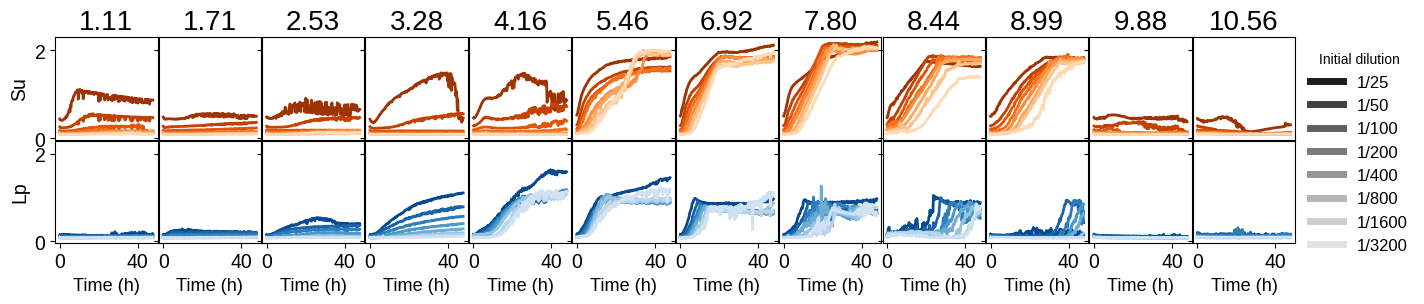

In [31]:
ini_pH = pd.read_csv('SL_growth_diffpH_inipH.csv', index_col=0).to_numpy()
gc_arr, tps = read_od_series('SL_growth_diffpH.csv', combt=True, pltshape=[16, 24])

fig, axes = plt.subplots(2, 12, figsize=[16, 8/3], sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.01, wspace=0.01)
for isp in range(2):
    if isp == 0:
        colors = mpl.colormaps['Oranges']
        sp = 'Su'
    else:
        colors = mpl.colormaps['Blues']
        sp = 'Lp'
    for iph in range(12):
        # plt.sca(axes.flatten()[iph])
        plt.sca(axes[isp, iph])

        for idil in range(8):
            plt.plot(tps, gc_arr[idil * 2, iph * 2 + isp], color=colors(1 - 0.1 * (idil + 1)), lw=2)
            plt.plot([], [], color=mpl.colormaps['Greys'](1 - 0.1 * (idil + 1)), label=f'1/{25 * 2 ** idil}')  # just to get the legend
    axes[isp, 0].set_ylabel(f'{sp}', fontsize=14)  # OD600
for iph in range(12):
    axes[0, iph].set_title(f'{ini_pH[:, iph].mean():.2f}')
    axes[1, iph].set_xlabel('Time (h)', fontsize='13')
    axes[1, iph].set_xticks([0, 40])
        

axes[0, -1].legend(loc='upper left', bbox_to_anchor=(1, 1), title='Initial dilution')
# fig.savefig('sup_SL_growthcurve_diff_pH.svg')

/tmp/ipykernel_265334/1549731063.py:19: RuntimeWarning: Mean of empty slice
  r_arr = np.log(2) / np.nanmean(t_dbl_arr, axis=0)


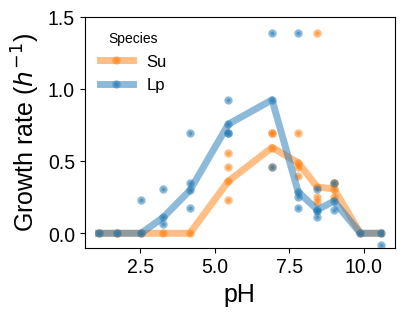

In [34]:
# growth rate
plt.figure(figsize=(4, 3))
isp = 0
for isp in range(2):
    thre = [0.5, 0.2][isp]
    color = mpl.colormaps['tab10']((1, 0))[isp]
    label = ['Su', 'Lp'][isp]

    t2thre_arr = np.zeros((8, 12))  # ndil * npH
    t2thre_arr[:, :] = np.nan
    for iph in range(12):
        for idil in range(8):
            idxes_thre = np.where(gc_arr[idil * 2, iph * 2 + isp] > thre)[0]
            if idxes_thre.size > 0:
                t2thre_arr[idil, iph] = tps[idxes_thre[0]]

    t_dbl_arr = t2thre_arr[2::2, :] - t2thre_arr[1:-1:2, :]  # 3 pairs of adjacent growth curves (differ by dilution factor 2)
    r_arr_raw = np.log(2) / t_dbl_arr
    r_arr = np.log(2) / np.nanmean(t_dbl_arr, axis=0)
    r_arr = np.where(np.isnan(t_dbl_arr).sum(axis=0) > 1, 0, r_arr)
    plt.plot(ini_pH.mean(axis=0), r_arr, '.-', color=color, linewidth=5, alpha=0.5, label=label)
    # plt.errorbar(ini_pH.mean(axis=0), r_arr, xerr=np.std(ini_pH, axis=0), yerr=np.std(r_arr_raw, axis=0), fmt='.-', color=color, linewidth=5, capsize=1, alpha=0.5)
    plt.plot(ini_pH.mean(axis=0), r_arr_raw.T, '.', color=color, linewidth=5, alpha=0.5)
plt.ylim([-0.1, 1.5])
plt.xlabel('pH')
plt.ylabel('Growth rate ($h^{-1}$)')
plt.legend(title='Species')
# plt.gcf().savefig('sup_SL_growthrate_diff_pH.svg', bbox_inches='tight')


## Multi-strain system

### Resident community species composition (FigS2b)

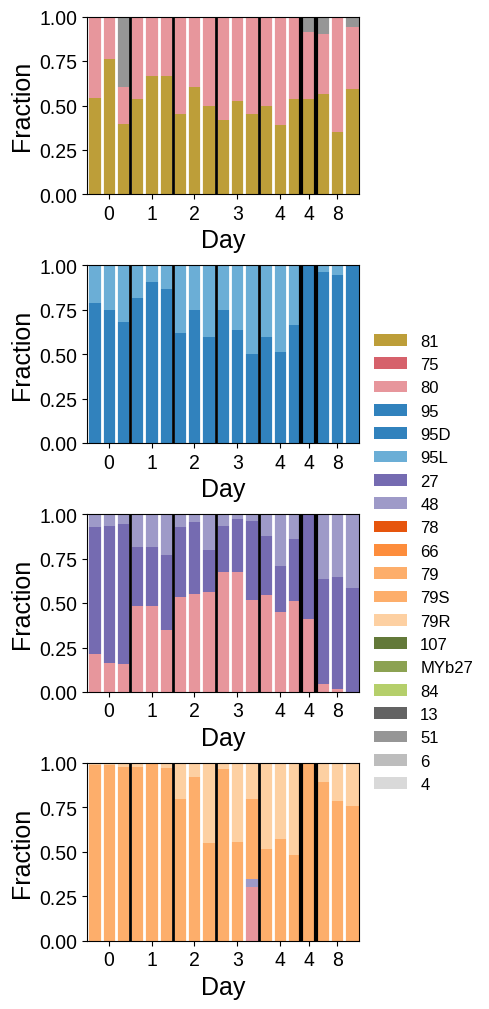

In [15]:
sp_color_dict = {'81': mpl.colormaps['tab20b'](9),
                 '75': mpl.colormaps['tab20b'](14),
                 '80': mpl.colormaps['tab20b'](15),
                 '95': mpl.colormaps['tab20c'](0),
                 '95D': mpl.colormaps['tab20c'](0),
                 '95L': mpl.colormaps['tab20c'](1),
                 '27': mpl.colormaps['tab20c'](12),
                 '48': mpl.colormaps['tab20c'](13),
                 '78': mpl.colormaps['tab20c'](4),
                 '66': mpl.colormaps['tab20c'](5),
                 '79': mpl.colormaps['tab20c'](6),
                 '79S': mpl.colormaps['tab20c'](6),
                 '79R': mpl.colormaps['tab20c'](7),
                 '107': mpl.colormaps['tab20b'](4),
                 'MYb27': mpl.colormaps['tab20b'](5),
                 '84': mpl.colormaps['tab20b'](6),
                 '13': mpl.colormaps['tab20c'](16),
                 '51': mpl.colormaps['tab20c'](17),
                 '6': mpl.colormaps['tab20c'](18),
                 '4': mpl.colormaps['tab20c'](19)
                }

df_cm_cfu = pd.read_excel('CM_comm_stability.xlsx', sheet_name='preculture_cfu', index_col=[0, 1], skiprows=1, nrows=16)
df_cm_16s = pd.read_excel('CM_comm_stability.xlsx', sheet_name='preculture_16Sseq_day4', header=0, nrows=17, index_col=0)
df_cm_16s.index = df_cm_16s.index.astype(str)
df_cfu_d8 = pd.read_excel('CM_comm_stability.xlsx', sheet_name='invasion_cfu_day8', header=0, index_col=0)

fig, axes = plt.subplots(4, 1, figsize=(3.5, 12))
plt.subplots_adjust(hspace=0.4)
icomm = 3
for icomm in range(4):
    plt.sca(axes[icomm])
    plot_communities(comm_list=np.concatenate([[cfu_str2dict(cfu_str) for cfu_str in df_cm_cfu.iloc[:, icomm]], 
                                               [dict(zip(df_cm_16s.index, df_cm_16s.iloc[:, icomm]))],
                                               [cfu_str2dict(cfu_str) for cfu_str in df_cfu_d8.iloc[icomm, :]]]),
                     sp_list=list(sp_color_dict.keys()), 
                     norm='linear', width=1, sp_colors=list(sp_color_dict.values()))#x_values=[1, 5, 9, 2, 6, 10, 3, 7, 11, 4, 8, 12])
    # plot_communities([dict(zip(df_cm_16s.index, df_cm_16s.iloc[:, icomm]))], sp_list=list(sp_color_dict.keys()), 
    #                  norm='linear', width=1, sp_colors=list(sp_color_dict.values()), x_values=13)
    for x in range(19):
        plt.plot([x + 0.5, x + 0.5], [0, 1], 'w-', lw=2)
        if x in [3, 6, 9, 12]:
            plt.plot([x + 0.5, x + 0.5], [0, 1], 'k-', lw=2)
        if x in [15, 16]:
            plt.plot([x + 0.5, x + 0.5], [0, 1], 'k-', lw=3)
    plt.xlim([0.5, 19.5])
    plt.ylim([0, 1])
    plt.xticks([2, 5, 8, 11, 14, 16, 18], [0, 1, 2, 3, 4, 4, 8])
    plt.xlabel('Day')
    plt.ylabel('Fraction')
plt.legend(bbox_to_anchor=(1, 3.5))
# plt.savefig(f'./figs_python/sup_CM_composition.svg', bbox_inches='tight')

### Resident community composition on day 8 of invasion

### Resident community pH change (FigS2a)

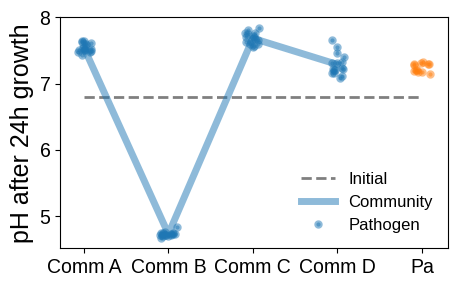

In [40]:
trm_list = ['Comm A', 'Comm B', 'Comm C', 'Comm D']

cm_fin_pH = pd.read_excel('CM_pH.xlsx', skiprows=1, usecols=range(2, 6)).to_numpy().T[:, ::-1]
pa_fin_pH = pd.read_excel('CM_pH.xlsx', 'Pa', usecols=range(2, 3)).to_numpy().T

plt.figure(figsize=[5, 3])
plt.plot(range(5), 6.8 * np.ones(5), 'k--', alpha=0.5, label='Initial', lw=2)
# community
color = mpl.colormaps['tab10'](0)
label = 'Community'
plt.plot(range(4), cm_fin_pH.mean(axis=1), '-', color=color, linewidth=5, alpha=0.5, label=label)
plt.plot(np.arange(4).reshape([4, 1]) + np.random.random(cm_fin_pH.shape) * 0.2 - 0.1, cm_fin_pH, '.', color=color, linewidth=5, alpha=0.5)
color = mpl.colormaps['tab10'](1)
label = 'Pa'
plt.plot(np.arange(4, 5).reshape([1, 1]) + np.random.random(pa_fin_pH.shape) * 0.2 - 0.1, pa_fin_pH, '.', color=color, linewidth=5, alpha=0.5, label=label)

plt.legend(['Initial', 'Community', 'Pathogen'])
np.concatenate((trm_list, ['Pa']))
plt.ylabel('pH after 24h growth')
plt.xticks(range(5), np.concatenate([trm_list, ['Pa']]))
plt.show()
# plt.gcf().savefig('sup_CM_pH_change.svg', bbox_inches='tight')

### Resident community OD

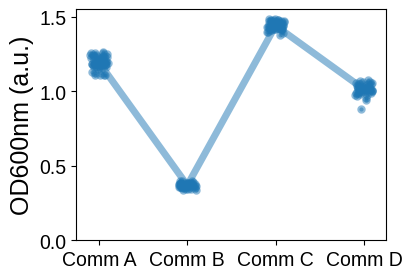

In [18]:
trm_list = ['Comm A', 'Comm B', 'Comm C', 'Comm D']

cm_od = pd.read_csv('CM_OD.csv', header=0, index_col=0).to_numpy().T

fig = plt.figure(figsize=[4, 3])
# community
color = mpl.colormaps['tab10'](0)
plt.plot(range(4), cm_od.mean(axis=1), '-', color=color, linewidth=5, alpha=0.5)
plt.plot(np.arange(4).reshape([4, 1]) + np.random.random(cm_od.shape) * 0.2 - 0.1, cm_od, '.', color=color, linewidth=5, alpha=0.5)

plt.ylabel('OD600nm (a.u.)')
plt.xticks(range(4), trm_list)
plt.ylim([0, 1.55])
fig.savefig('./figs_python/sup_CM_OD.svg', bbox_inches='tight')

# Fig - Invasion experiments

## Two-strain system

### Raw invasion waves (FigS6)

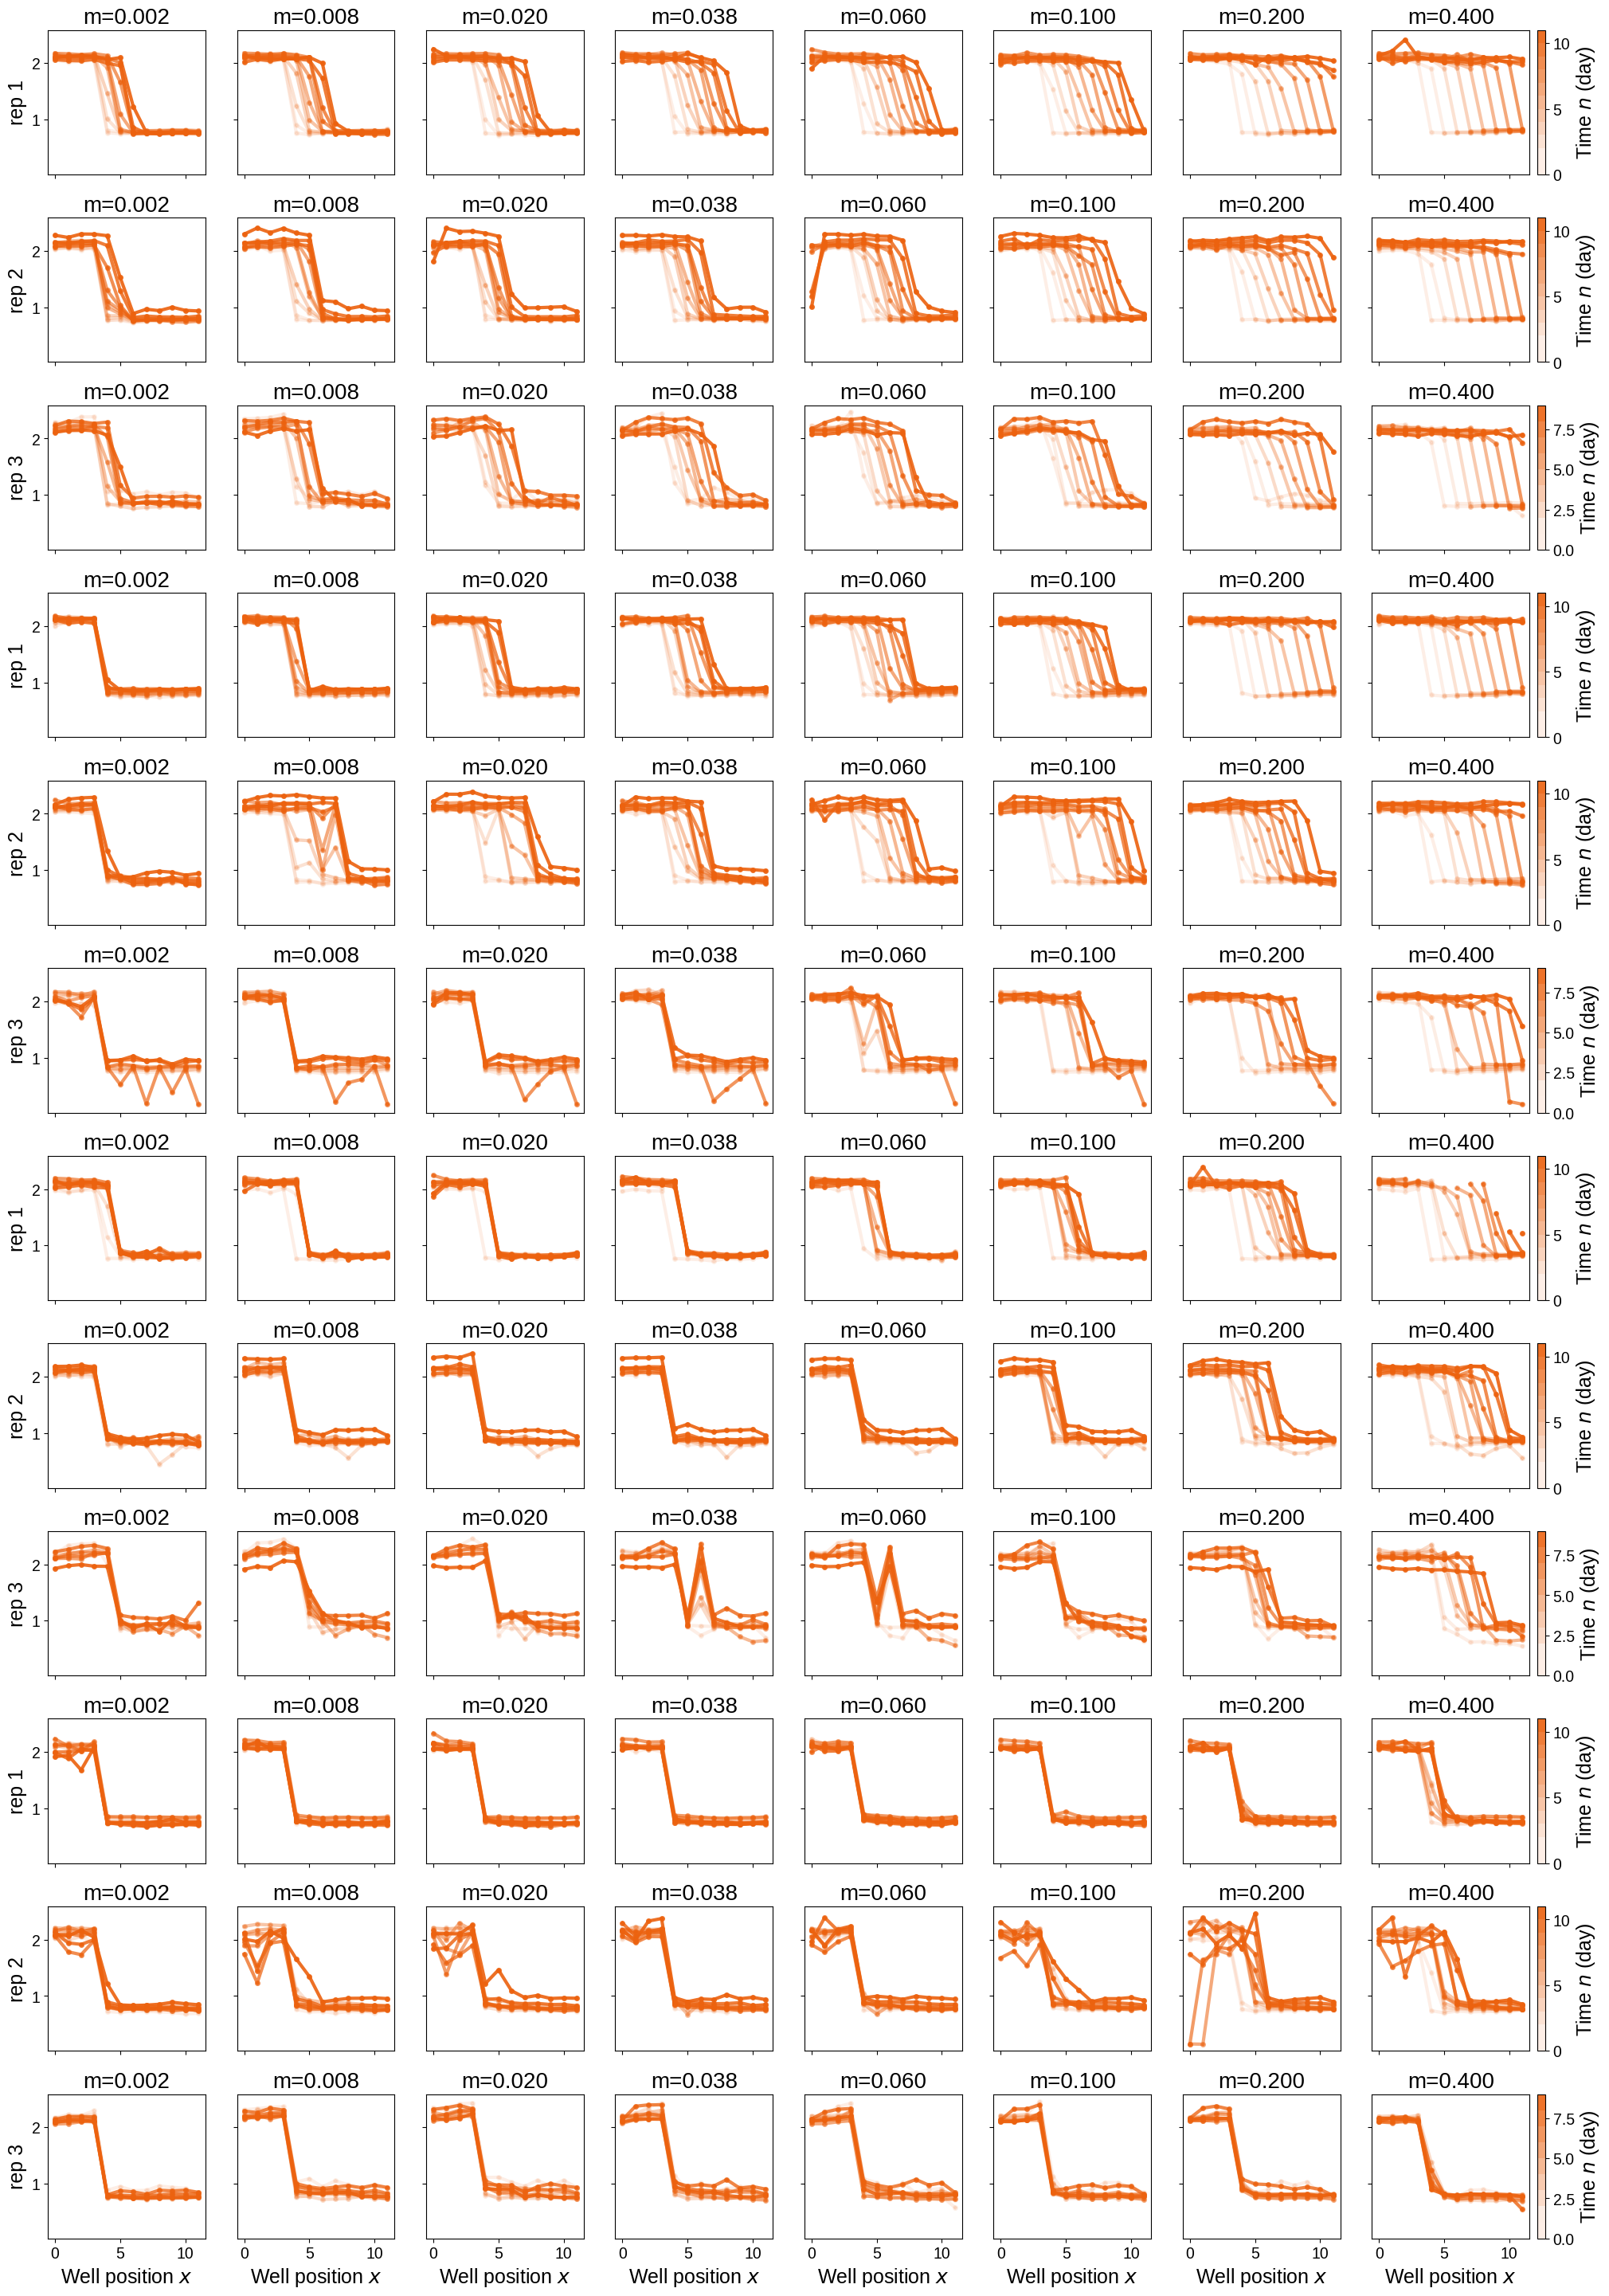

In [47]:
trm_list = copy.deepcopy(trm_list_2s)
rep_list_dict = copy.deepcopy(rep_list_dict_2s)
m_list_dict = copy.deepcopy(m_list_dict_2s)
od_arr_dict = copy.deepcopy(od_arr_dict_2s)
od_arr_normed_dict = copy.deepcopy(od_arr_normed_dict_2s)
ws_exp_dict = copy.deepcopy(ws_exp_dict_2s)

fig, axes = plt.subplots(4 * 3, 8, figsize=[24, 36], sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3)
for irep in range(3):
    for itrm in range(4):
        trm = trm_list[itrm]
        exp_key = rep_list_dict[trm][irep]
        iax = (3 - itrm) * 3 + irep
        for im in range(8):
            m = m_list_dict[exp_key][im]
            iax2 = im
            if np.isnan(iax2):
                pass
            else:
                plt.sca(axes[iax, iax2])
                # data = np.squeeze(od_arr_normed_dict[trm][irep][:, im, :])
                data = np.squeeze(od_arr_dict[trm][irep][:, im, :])
                draw_wave(data, fig=fig, cbar=(im == 7))
                # plt.plot([0, 11], [0.5, 0.5], 'k--', lw=2, alpha=0.5)
                if iax2 == 0:
                    # plt.ylabel('Normalized invader \n (luminescence)')
                    plt.ylabel(f'rep {irep + 1}')
                else:
                    plt.ylabel('')
                plt.title(f'm={m:.3f}')
                if iax < axes.shape[0] - 1:
                    plt.xlabel('')
                # plt.ylim([-0.1, 1.1])
                # plt.plot(range(12), [1] * 4 + [0] * 8, 'k--', lw=2)
# fig.savefig('sup_raw_waves_simple.svg', bbox_inches='tight')

### Example invasion waves (Fig2c)

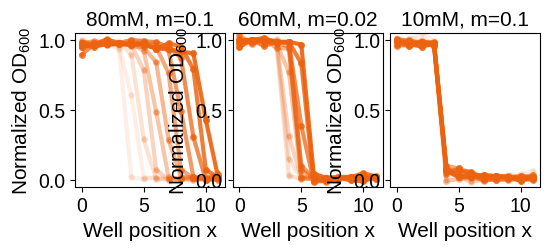

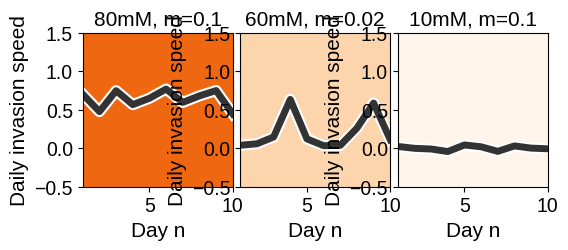

In [48]:
trm_list = copy.deepcopy(trm_list_2s)
rep_list_dict = copy.deepcopy(rep_list_dict_2s)
m_list_dict = copy.deepcopy(m_list_dict_2s)
od_arr_dict = copy.deepcopy(od_arr_dict_2s)
od_arr_normed_dict = copy.deepcopy(od_arr_normed_dict_2s)
ws_exp_dict = copy.deepcopy(ws_exp_dict_2s)

irep = 0
im_list = [5, 2, 5]
itrm_list = [3, 2, 0]

fig1, axes1 = plt.subplots(1, 3, figsize=(6, 2), sharex=True, sharey=False)
for iax in range(3):
    im = im_list[iax]
    itrm = itrm_list[iax]
    trm = trm_list[itrm]
    plt.sca(axes1[iax])
    plt.title(f'{trm}, m={m_list_dict[rep_list_dict[trm][irep]][im]}', fontsize=15)
    draw_wave(np.squeeze(od_arr_normed_dict[trm][irep][:, im, :]), fig=fig1, cbar=False)
    plt.ylabel(r'Normalized OD$_{\mathregular{600}}$', fontsize=15)
    plt.xlabel('Well position x', fontsize=15)
    plt.ylim([-0.05, 1.05])
    plt.xticks([0, 5, 10])
plt.subplots_adjust(wspace=0.05)

fig2, axes2 = plt.subplots(1, 3, figsize=(6, 2), sharex=True, sharey=False)
for iax in range(3):
    im = im_list[iax]
    itrm = itrm_list[iax]
    trm = trm_list[itrm]
    plt.sca(axes2[iax])
    plt.title(f'{trm}, m={m_list_dict[rep_list_dict[trm][irep]][im]}', fontsize=15)
    draw_wave_speeds(np.squeeze(ws_exp_dict[trm][irep, im]), ax=axes2[iax])
    plt.ylabel('Daily invasion speed', fontsize=15)
    plt.xlabel('Day n', fontsize=15)
    plt.ylim([-0.5, 1.5])
    plt.xlim([1, 10])
    plt.yticks([-0.5, 0, 0.5, 1, 1.5])
plt.subplots_adjust(wspace=0.05, hspace=0.0)

# fig1.savefig('SL_example_wave.svg', bbox_inches="tight")
# fig2.savefig('SL_example_v_n.svg', bbox_inches="tight")

### Phase diagram (Fig2d)

(-0.5, 1.5)

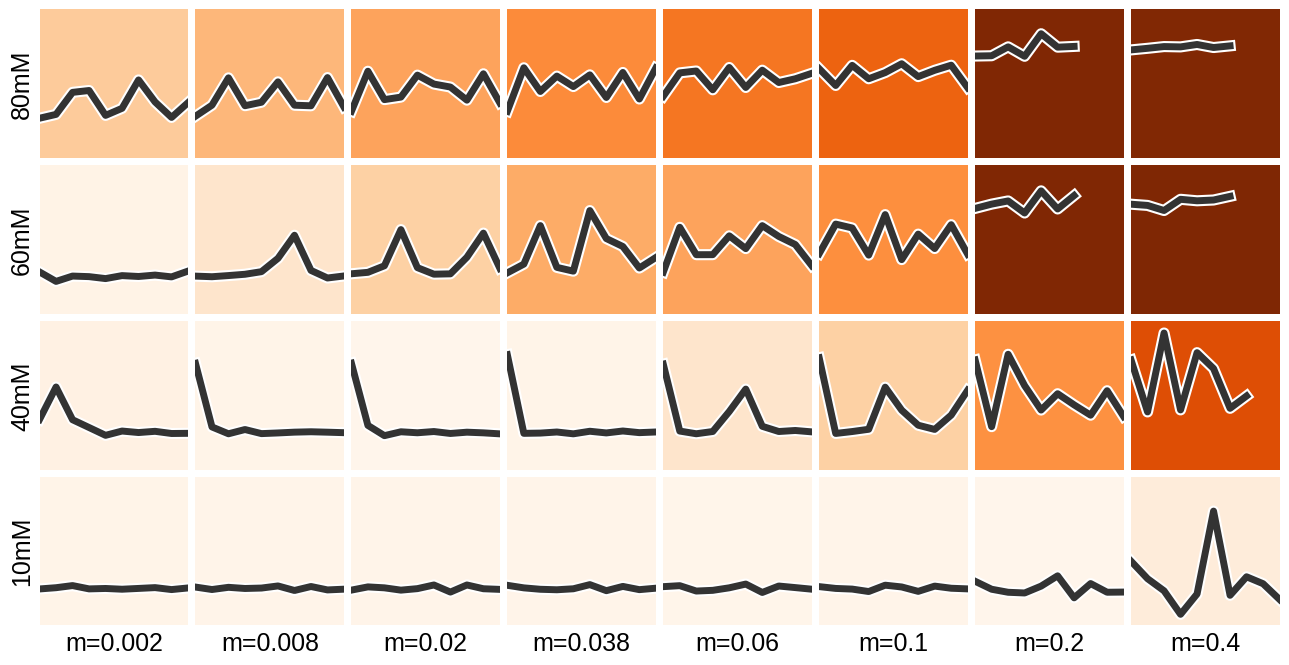

In [59]:
trm_list = copy.deepcopy(trm_list_2s)
rep_list_dict = copy.deepcopy(rep_list_dict_2s)
m_list_dict = copy.deepcopy(m_list_dict_2s)
od_arr_dict = copy.deepcopy(od_arr_dict_2s)
od_arr_normed_dict = copy.deepcopy(od_arr_normed_dict_2s)
ws_exp_dict = copy.deepcopy(ws_exp_dict_2s)

# Select the representative experiment for plotting
exp = ['exp20230207', 'exp20230511']
idx_exp = 0  # 0 or 1
day_list = copy.deepcopy(day_list_dict_2s[exp[idx_exp]])
ws_raw = np.zeros((4, 8, len(day_list) - 1))  # wave speeds, 4 trm * 8 m * n day.
ws_raw[:, :, :] = np.nan
m_list = copy.deepcopy(m_list_dict[exp[idx_exp]])

plot_order = [3, 2, 1, 0]
for ii in range(4):
    itrm = plot_order[ii]
    trm = trm_list[itrm]
    for im in range(8):
        ws_raw[ii, im, :] = ws_exp_dict[trm][idx_exp, im]

# Calculate the mean for each time series
ws_mean = np.nanmean(ws_raw[:, :, 2:], axis=2)

fig, axs = plt.subplots(4, 8, figsize=(16, 8), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Define color scaling based on the mean values
vmax = np.nanmax(ws_mean)
vmin = np.nanmin(ws_mean)
cmap = plt.cm.Oranges

# Define line color and path effects for the time series
linecolor = [0.2, 0.2, 0.2]
strokecolor = 'white'

for i in range(4):  # itrm, for each treatment
    for j in range(8):  # im, for each dispersal rate
        # Set background color based on the mean value
        normalized_mean = (ws_mean[i, j] - vmin) / (vmax - vmin)
        facecolor = cmap(normalized_mean)
        axs[i, j].set_facecolor(facecolor)

        # Plot the time series directly
        axs[i, j].plot(day_list[1:], ws_raw[i, j],
                       color=linecolor,
                       path_effects=[pe.Stroke(linewidth=8, foreground=strokecolor), pe.Normal()])

        # Hide axis spines, ticks, and tick labels
        axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        for spine in axs[i, j].spines.values():
            spine.set_visible(False)

        # Add custom axis labels
        if i == 3:  # For the bottom-most row
            axs[i, j].set_xlabel(f"m={m_list[j]}")
        if j == 0:  # For the left-most column
            axs[i, j].set_ylabel(f"{trm_list[3 - i]}")

plt.xlim([1, 10])
plt.ylim([-0.5, 1.5])
# fig.savefig('sl_phasediagram.svg')


## Invasion experiment with daily CFU in two-strain system (FigS5)

### Load data

In [32]:
df = pd.read_excel('SL_mig_CFU_timeseries_40mM.xlsx', header=None)
m_list = m_list_dict_2s['exp20230612']
nday, nmig, nwell = 9, 8, 12

daily_cfu_ivd = np.zeros([nday, nmig, nwell])
daily_cfu_ivd.fill(np.nan)
for ii in range(df.shape[0] // 10 + 1):
    day = int(df.iloc[ii * 10, 0].split()[-1])
    daily_cfu_ivd[day, :, :] = df.iloc[ii * 10 + 1 : ii * 10 + 9, 1:13]
daily_cfu_ivd[0, :, 4:] = 0  # append day 0
daily_cfu_ivd[:, :, :4] = 10e6  # first 4 wells plated but not counted, approximate with carrying capacity

### Plot invader CFU time series

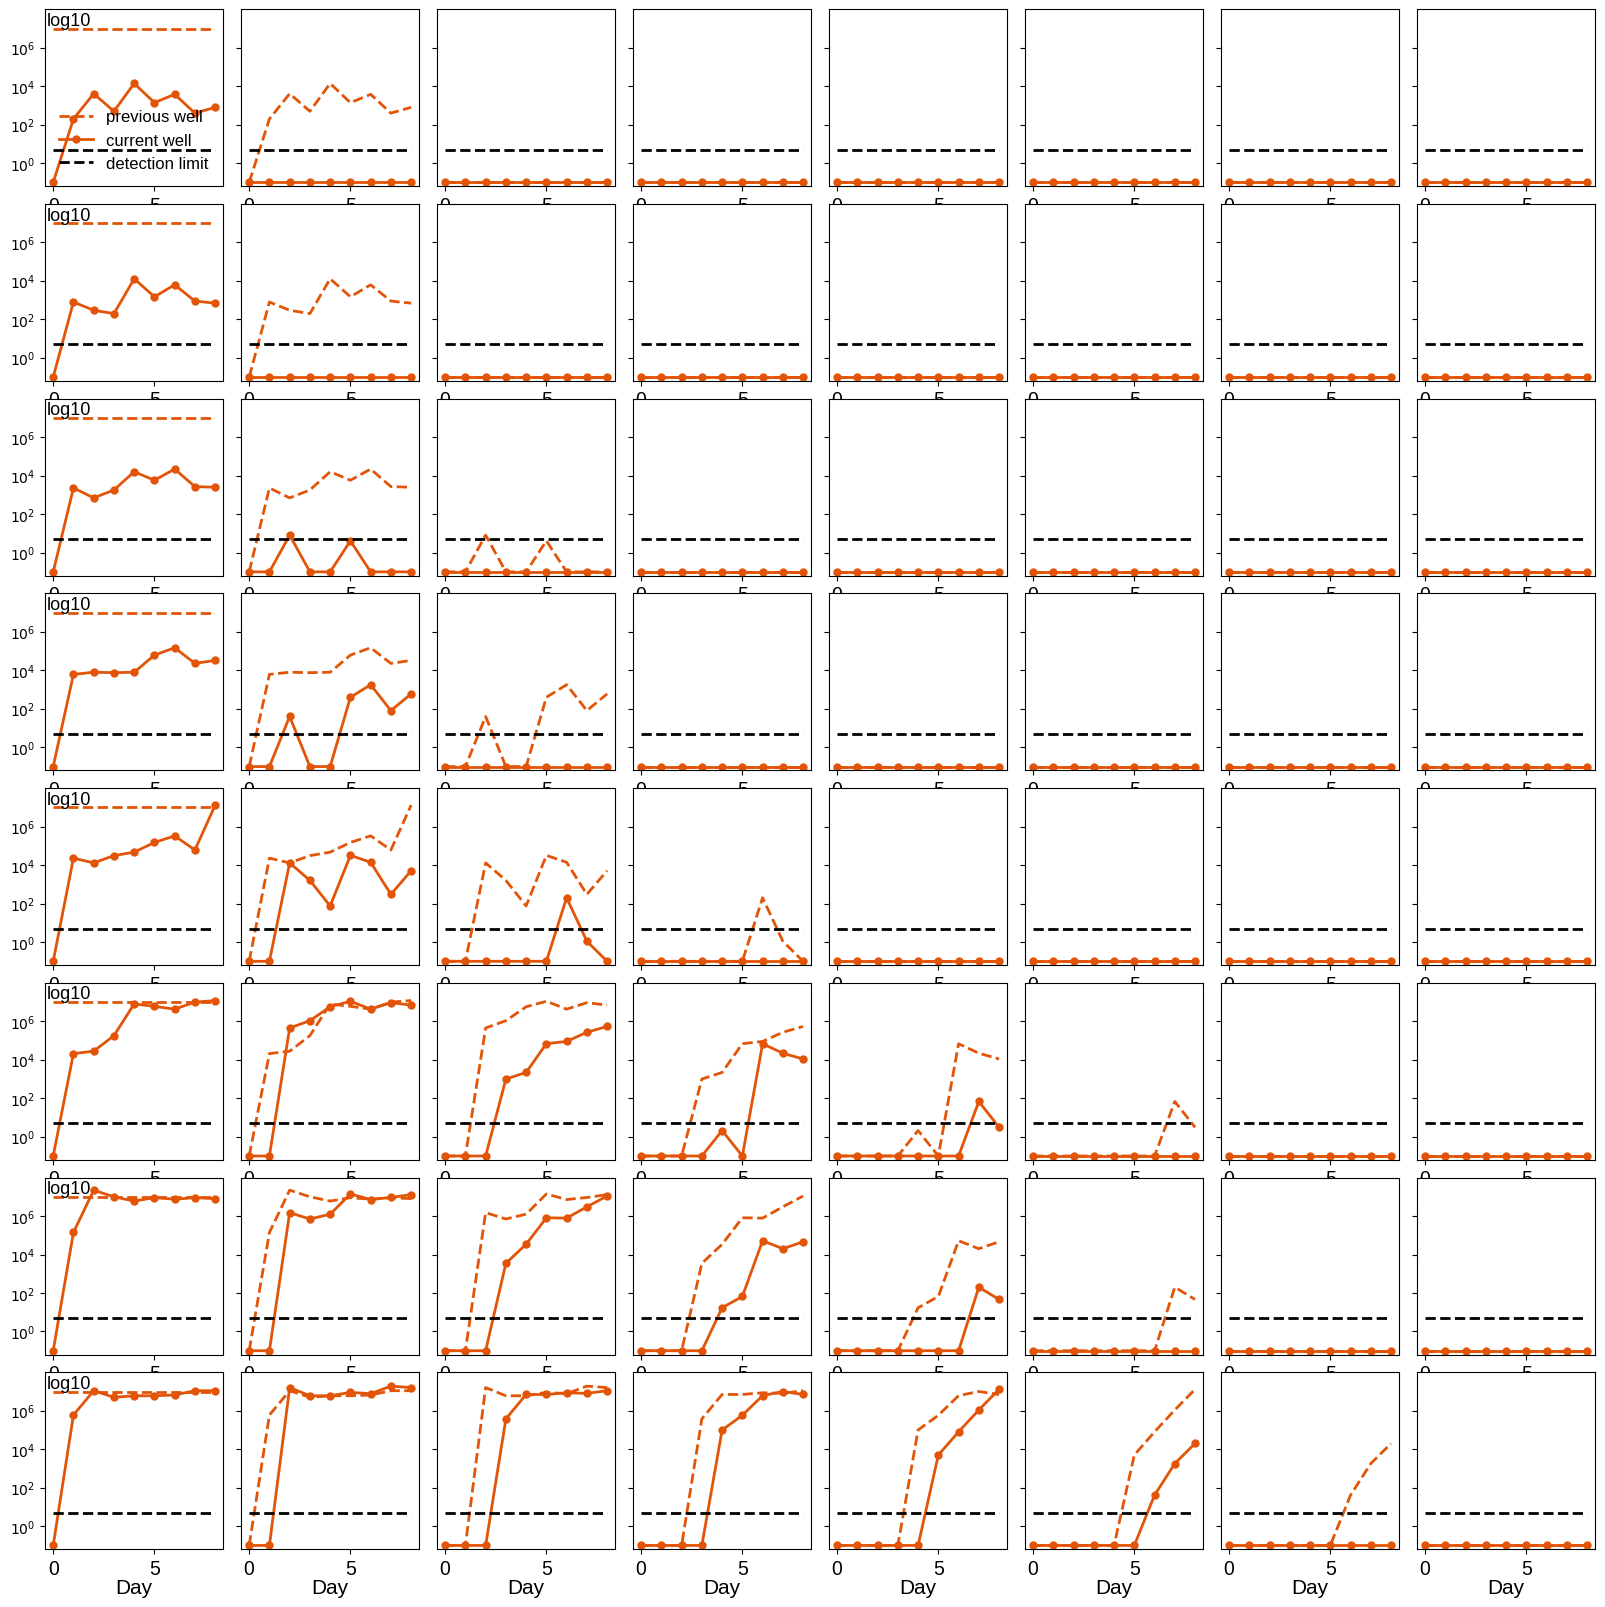

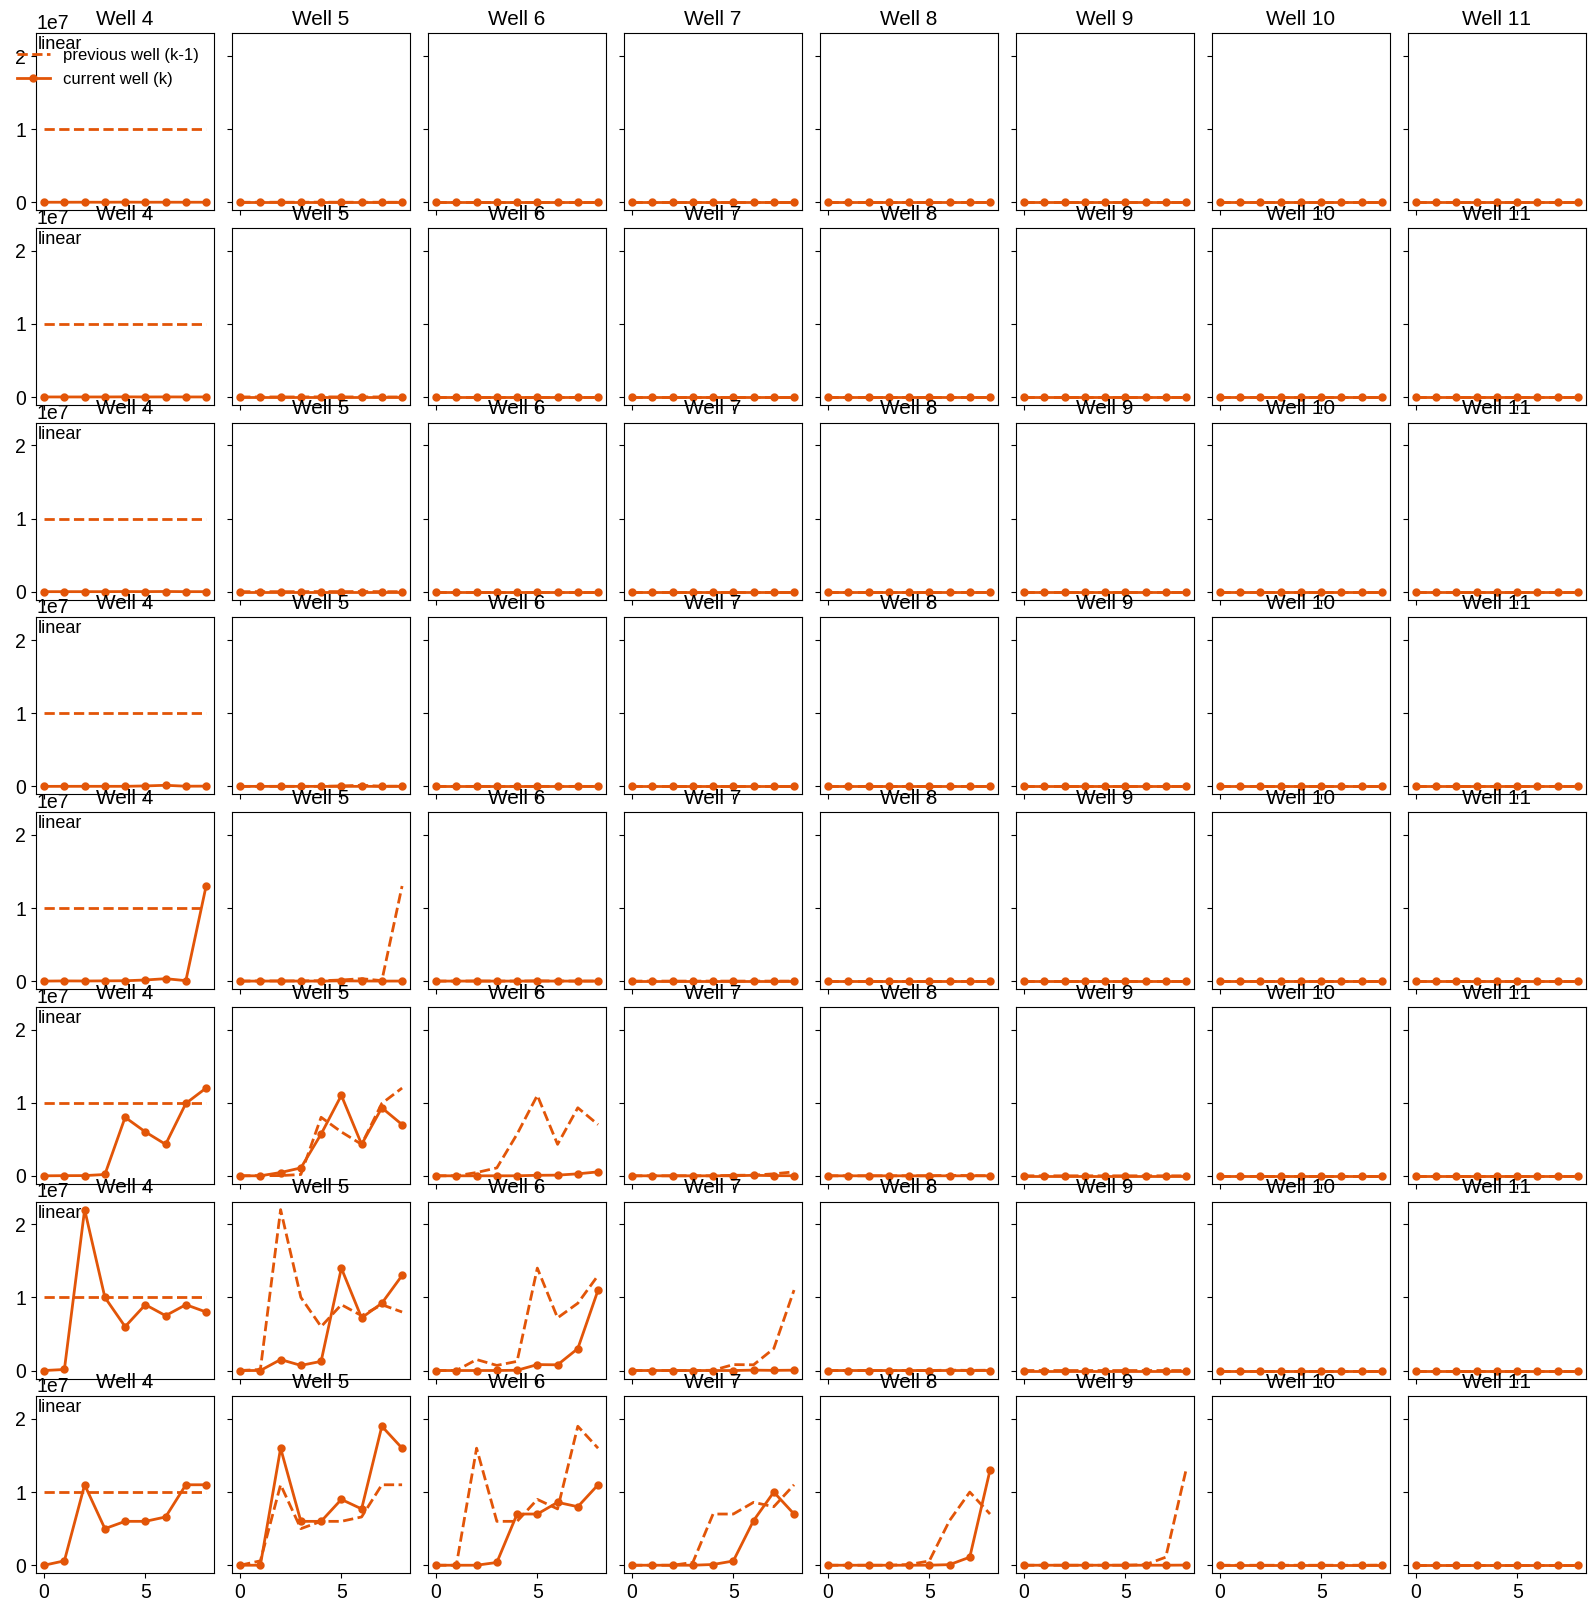

In [31]:
fig, axes = plt.subplots(nmig, nwell - 4, figsize=((nwell - 4) * 2.5, nmig * 2.5), sharex=False, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for im in range(nmig):
    for ic in range(4, nwell):
        plt.sca(axes[im, ic - 4])
        plt.plot(np.arange(nday), np.log10(daily_cfu_ivd[:, im, ic-1] + 0.1), '--' ,lw=2, color=mpl.colormaps['Oranges'](0.7))
        plt.plot(np.arange(nday), np.log10(daily_cfu_ivd[:, im, ic] + 0.1), '.-' ,lw=2, color=mpl.colormaps['Oranges'](0.7))
        plt.xlabel('Day', fontsize=15, labelpad=0)
        plt.plot([0, 8], np.log10([5, 5]), 'k--', lw=2)
        # plt.title(f'Well {ic}', fontsize=15)
        plt.yticks([0, 2, 4, 6], [f'$10^{power}$' for power in [0, 2, 4, 6]], fontsize=10)
        if ic == 4:
            plt.annotate('log10', [0.01, 0.91], fontsize=13, xycoords='axes fraction')
            if im == 0:
                plt.legend(['previous well', 'current well', 'detection limit'])
# plt.xlim([-0.5, 8.5])
plt.ylim([-1.2, 8])
# plt.savefig('supfig_2_dailyCFUexample_singlewell_dynamics_log.svg', bbox_inches='tight')

fig2, axes2 = plt.subplots(nmig, nwell - 4, figsize=((nwell - 4) * 2.5, nmig * 2.5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for im in range(nmig):
    for ic in range(4, nwell):
        plt.sca(axes2[im, ic - 4])
        plt.plot(np.arange(nday), np.array(daily_cfu_ivd[:, im, ic-1] + 0.1), '--' ,lw=2, color=mpl.colormaps['Oranges'](0.7))
        plt.plot(np.arange(nday), np.array(daily_cfu_ivd[:, im, ic] + 0.1), '.-' ,lw=2, color=mpl.colormaps['Oranges'](0.7))
        # plt.xlabel('Day', fontsize=15)
        plt.title(f'Well {ic}', fontsize=15)
        if ic == 4:
            plt.annotate('linear', [0.01, 0.91], fontsize=13, xycoords='axes fraction')
            # plt.ylabel('Invader CFU / 5uL\nlinear scale', fontsize=15)
            if im == 0:
                plt.legend(['previous well (k-1)', 'current well (k)'])
# plt.ylim([-0.1e7, 1.9e7])
# plt.yticks([0, 1e7, 2e7], ['0e7', '1e7', '2e7'])
# plt.xlim([-0.5, 8.5])
# plt.savefig('supfig_2_dailyCFUexample_singlewell_dynamics_linear.svg', bbox_inches='tight')

### Plot wave speed phase diagram

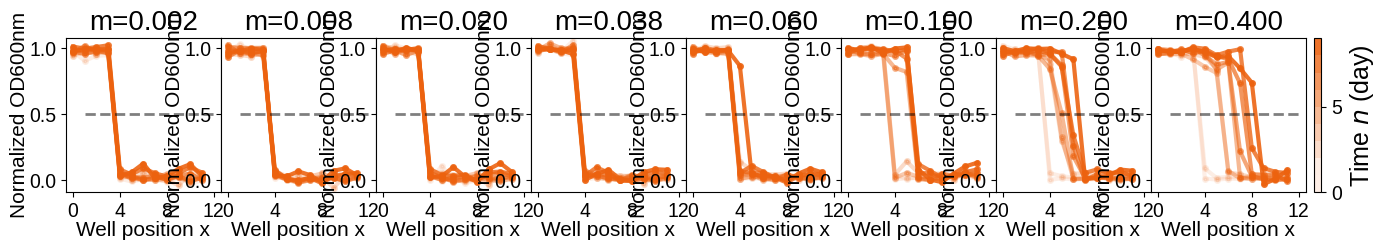

In [36]:
fig, axes = plt.subplots(1, 8, figsize=[16, 2], sharex=True, sharey=False)
axes = np.reshape(axes, [1, -1])
plt.subplots_adjust(wspace=0)
irep = 3
itrm = 1
trm = trm_list[itrm]
exp_key = rep_list_dict_2s[trm][irep]
iax = 0
for im in range(8):
    m = m_list_dict_2s[exp_key][im]
    iax2 = im
    if np.isnan(iax2):
        pass
    else:
        plt.sca(axes[iax, iax2])
        data = np.squeeze(od_arr_normed_dict_2s[trm][irep][:, im, :])
        # data = np.squeeze(od_arr_dict[trm][irep][:, im, :])
        draw_wave(data, fig=fig, cbar=(im == 7))
        plt.plot([1, 12], [0.5, 0.5], 'k--', lw=2, alpha=0.5)
        plt.ylabel('Normalized OD600nm', fontsize=15, labelpad=0)
        plt.xlabel('Well position x', fontsize=15, labelpad=0)
        plt.title(f'm={m:.3f}')
        plt.xticks([0, 4, 8, 12])
        plt.ylim([-0.09, 1.075])
        # plt.plot(range(12), [1] * 4 + [0] * 8, 'k--', lw=2)
# fig.savefig('supfig_2_dailyCFUexample_rawwave.svg')

(1.0, 8.0)

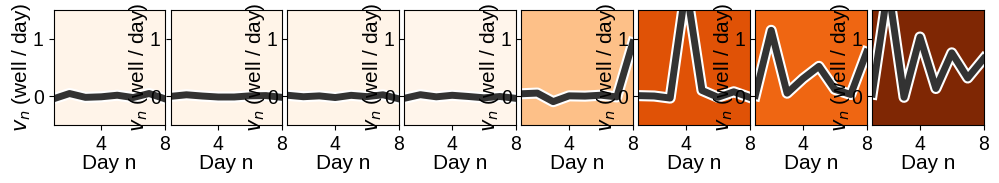

In [37]:
# summarize data
trm_list = copy.deepcopy(trm_list_2s)
data = np.zeros((1, 8, 8))  # 4 trm * 8 m * n day.
data[:, :, :] = np.nan
idx_exp = 3 
m_list = copy.deepcopy(m_list_dict_2s['exp20230612'])
time_points = np.arange(1, 9)

plot_order = [1]  # plot the 2nd treatment
for ii in range(1):
    itrm = plot_order[ii]
    trm = trm_list[itrm]
    for im in range(8):
        data[ii, im, :] = ws_exp_dict_2s[trm][idx_exp, im]

# Calculate the mean for each time series
means = np.nanmean(data[:, :, 2:], axis=2)

fig, axs = plt.subplots(1, 8, figsize=(1.5 * 8, 1.5), sharex=True, sharey=False)
axs = np.reshape(axs, [1, -1])
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Define color scaling based on the mean values
vmax = np.nanmax(means)
vmin = np.nanmin(means)
cmap = plt.cm.Oranges

# Define line color and path effects for the time series
linecolor = [0.2, 0.2, 0.2]
strokecolor = 'white'

for i in range(1):
    for j in range(8):
        # Set background color based on the mean value
        normalized_mean = (means[i, j] - vmin) / (vmax - vmin)
        facecolor = cmap(normalized_mean)
        axs[i, j].set_facecolor(facecolor)

        # Plot the time series directly
        axs[i, j].plot(time_points, data[i, j],
                       color=linecolor,
                       path_effects=[pe.Stroke(linewidth=8, foreground=strokecolor), pe.Normal()])

        # Hide axis spines, ticks, and tick labels
        axs[i, j].set_xticks([0, 4, 8])
        axs[i, j].set_xlabel('Day n', fontsize=15, labelpad=0)
        axs[i, j].set_ylabel('$v_n$ (well / day)', fontsize=15, labelpad=0)
        # axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        # for spine in axs[i, j].spines.values():
        #     spine.set_visible(False)

        # Add custom axis labels
        # axs[i, j].set_xlabel(f"m={m_list[j]}")
        # if j == 0:  # For the left-most column
        #     axs[i, j].set_ylabel(f"{trm_list[plot_order[i]]}")
        axs[i, j].set_ylim([-0.5, 1.5])

plt.xlim([1, 8])
# fig.savefig('supfig_2_dailyCFUexample_phasediagram.svg')


## Multi-strain system

### Raw invasion waves (FigS7)

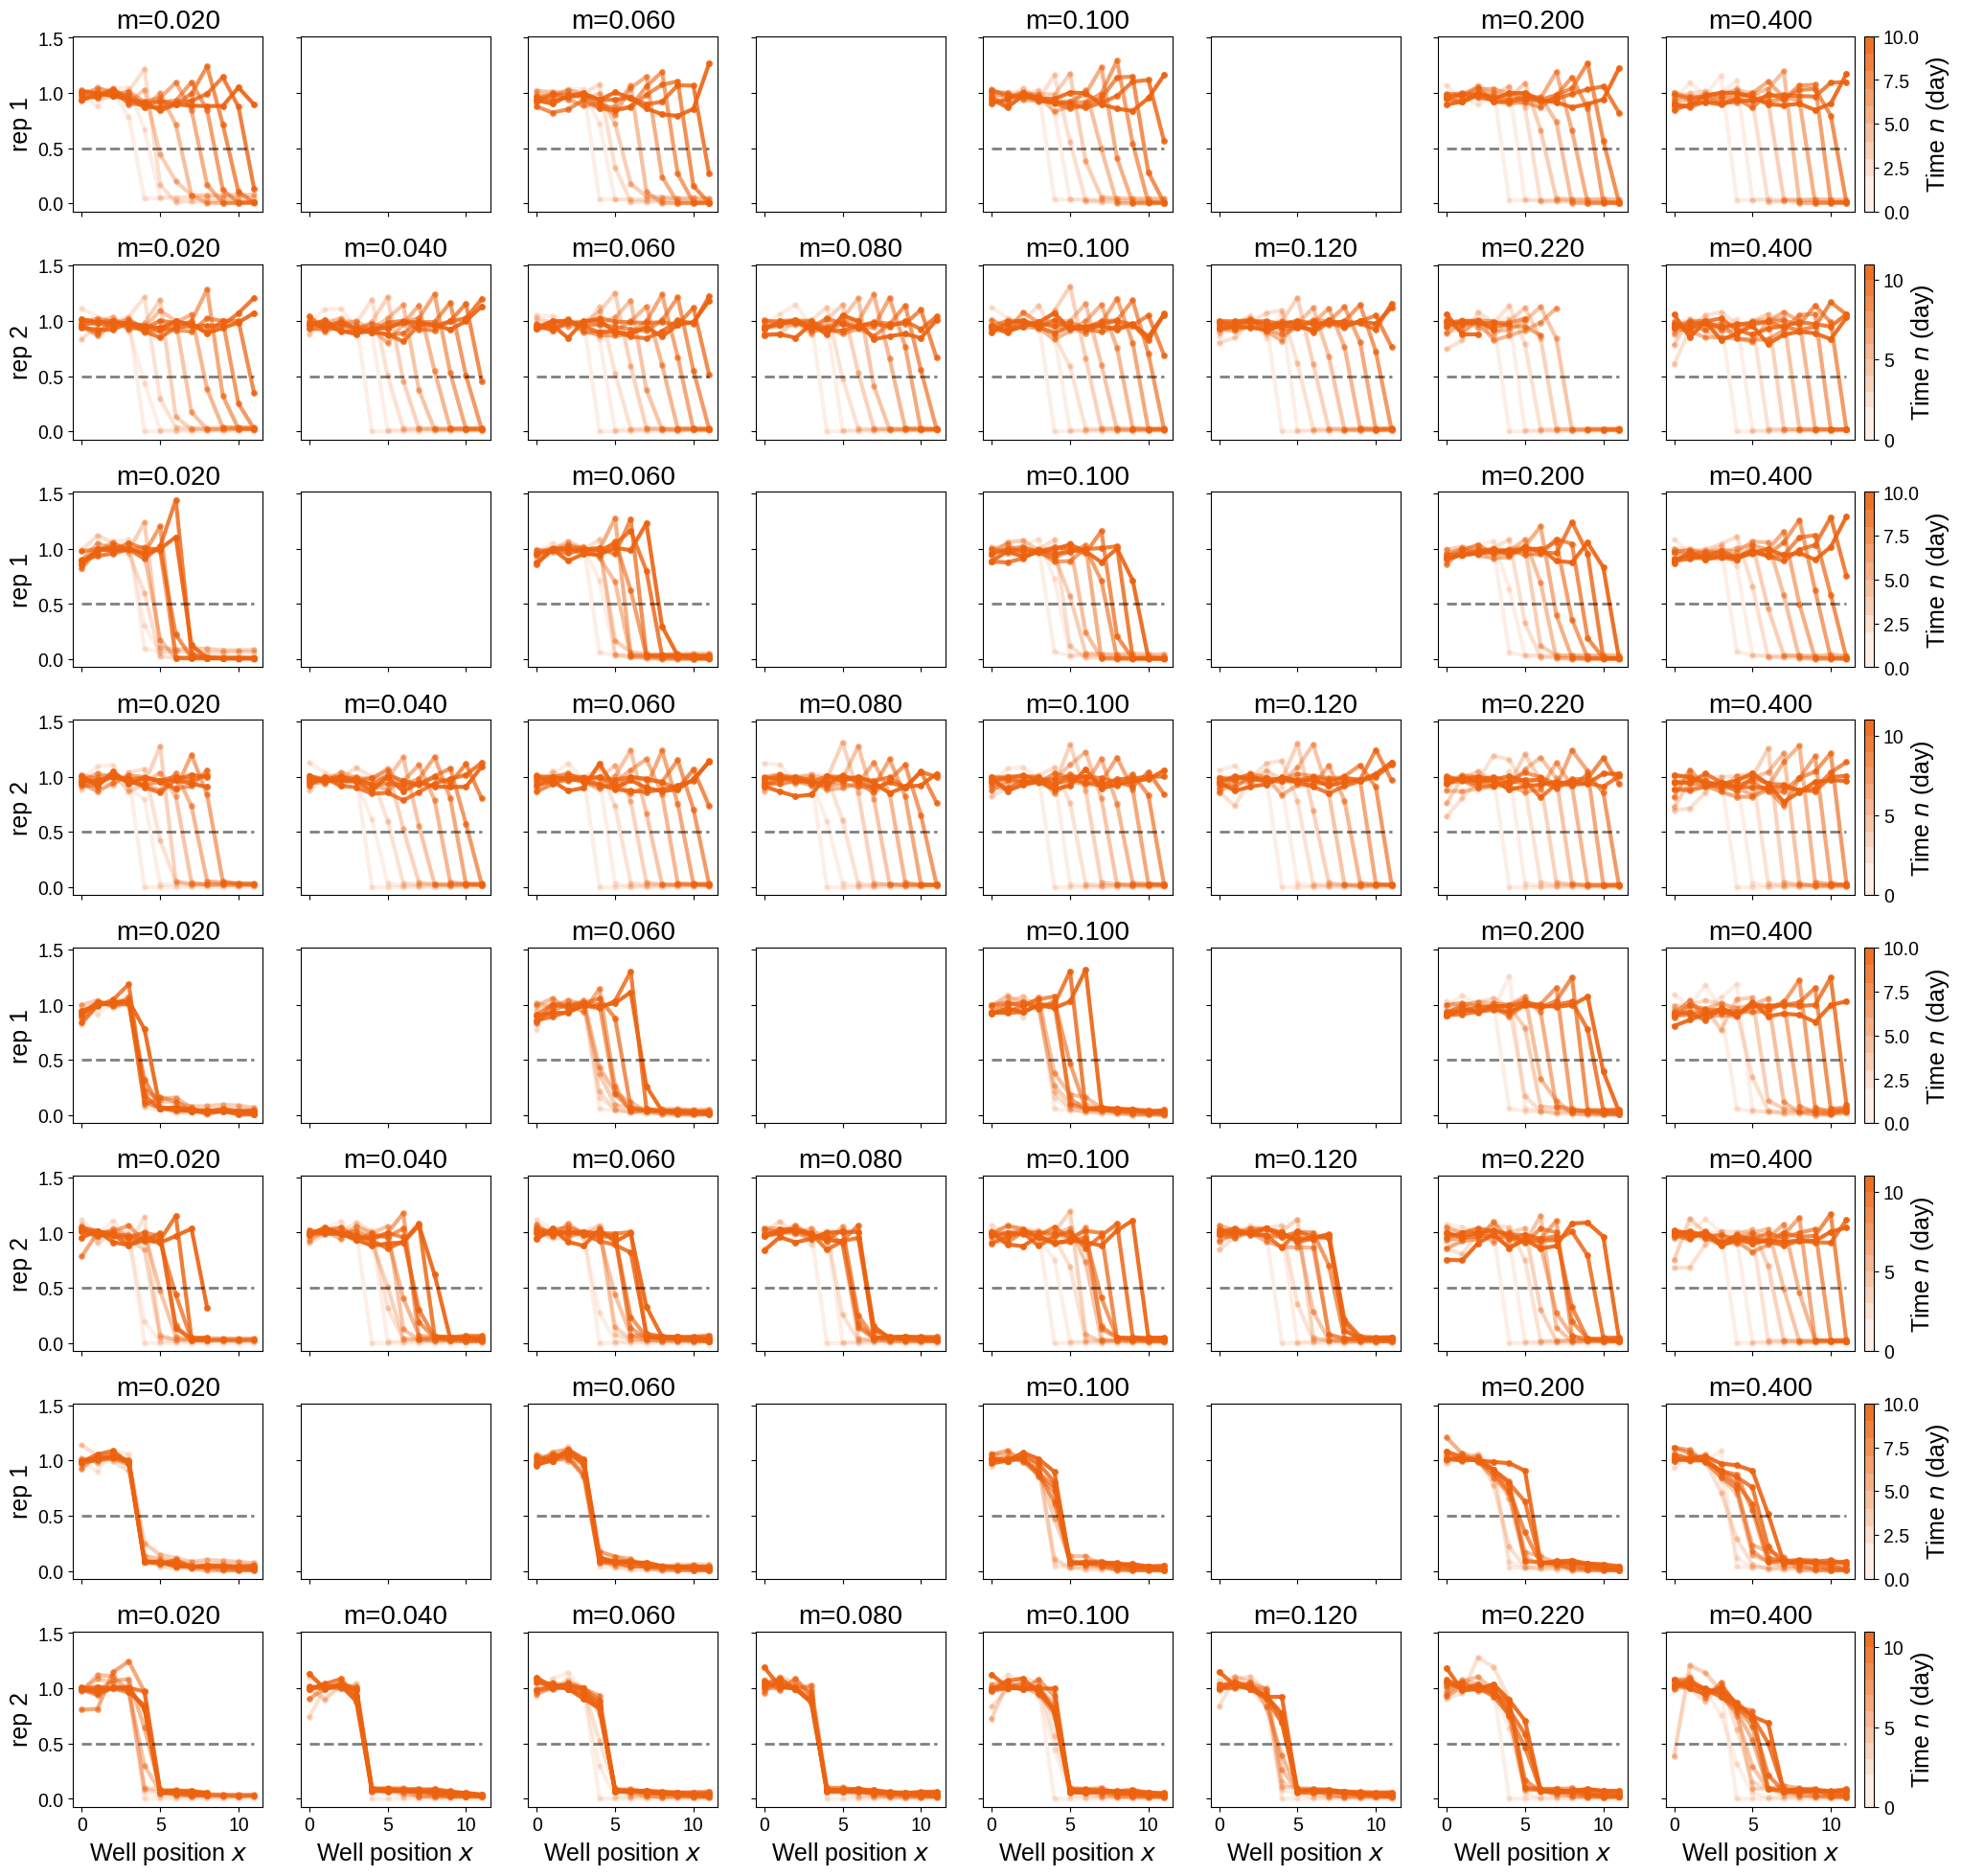

In [39]:
fig, axes = plt.subplots(4 * 2, 8, figsize=[24, 24], sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3)
for irep in range(2):
    exp_key = list(m_list_dict_ms.keys())[irep]
    for itrm in range(4):
        trm = trm_list_ms[itrm]
        iax = (3 - itrm) * 2 + irep
        for im in range(8):
            m = m_list_dict_ms[exp_key][im]
            if irep == 0:  # with also 1/100 as source plate, transfer not accurate and not comparable
                iax2 = [np.nan, np.nan, 0, np.nan, 2, 4, 6, 7][im]
            else:  # irep == 1
                iax2 = im
            if np.isnan(iax2):
                pass
            else:
                plt.sca(axes[iax, iax2])
                data = np.squeeze(luc_arr_normed_dict_ms[trm][irep][:, im, :])
                # data = np.squeeze(luc_arr_dict_ms[trm][irep][:, im, :])
                draw_wave(data, fig=fig, cbar=(im == 7))
                plt.plot([0, 11], [0.5, 0.5], 'k--', lw=2, alpha=0.5)
                if iax2 == 0:
                    # plt.ylabel('Normalized invader \n (luminescence)')
                    plt.ylabel(f'rep {irep + 1}')
                else:
                    plt.ylabel('')
                plt.title(f'm={m:.3f}')
                if iax < 7:
                    plt.xlabel('')
                # plt.plot(range(12), [1] * 4 + [0] * 8, 'k--', lw=2)
# fig.savefig('sup_raw_waves_complex_normed.svg', bbox_inches='tight')

### Phase diagram (Fig2e)

(-0.5, 1.5)

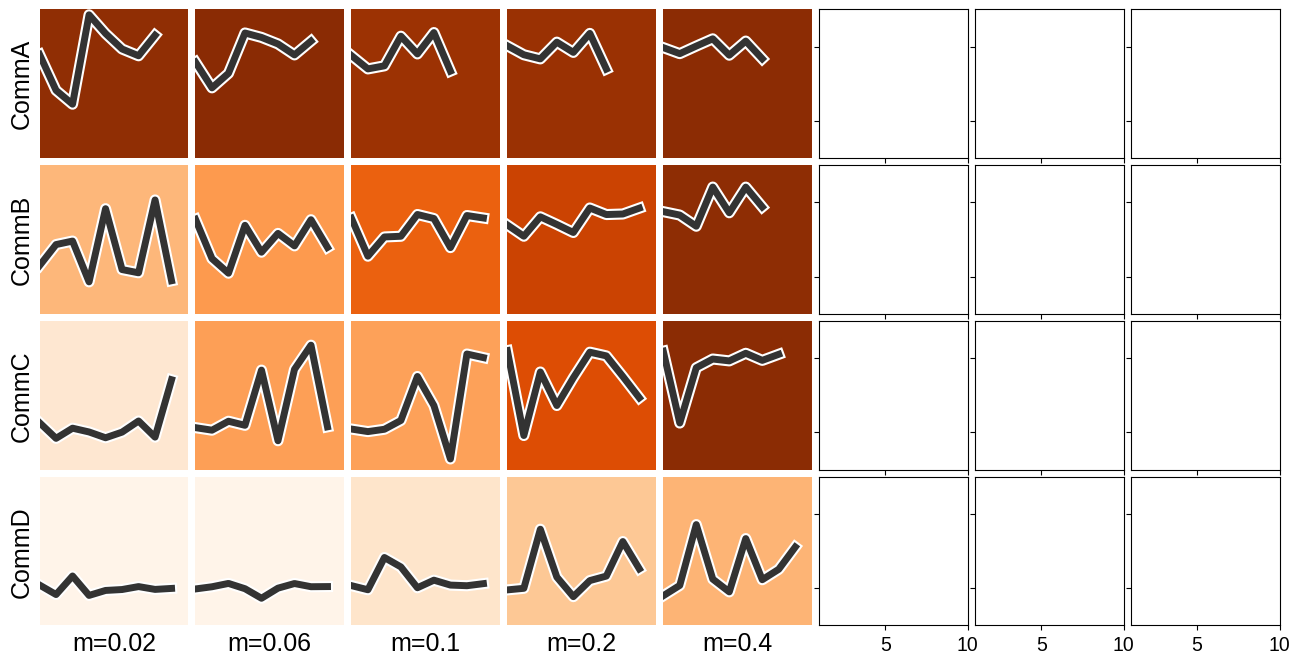

In [49]:
trm_list = copy.deepcopy(trm_list_ms)
rep_list_dict = copy.deepcopy(rep_list_dict_ms)
m_list_dict = copy.deepcopy(m_list_dict_ms)
luc_arr_dict = copy.deepcopy(luc_arr_dict_ms)
luc_arr_normed_dict = copy.deepcopy(luc_arr_normed_dict_ms)
ws_exp_dict = copy.deepcopy(ws_exp_dict_ms)

# Select the representative experiment for plotting
exp = ['exp20230511', 'exp20230829']
idx_exp = 0  # 0 or 1
day_list = copy.deepcopy(day_list_dict_ms[exp[idx_exp]])
ws_raw = np.zeros((4, 8, len(day_list) - 1))  # wave speeds, 4 trm * 8 m * n day.
ws_raw[:, :, :] = np.nan
m_list = copy.deepcopy(m_list_dict[exp[idx_exp]])
        
for itrm in range(4):
    trm = trm_list[itrm]
    for im in range(8):
        ws_raw[itrm, im, :] = ws_exp_dict[trm][idx_exp, im]

# Calculate the mean for each time series
ws_mean = np.nanmean(ws_raw[:, :, 2:], axis=2)

fig, axs = plt.subplots(4, 8, figsize=(16, 8), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Define color scaling based on the mean values
vmax = np.nanmax(ws_mean)
vmin = np.nanmin(ws_mean)
cmap = plt.cm.Oranges

# Define line color and path effects for the time series
linecolor = [0.2, 0.2, 0.2]
strokecolor = 'white'

for i in range(4):  # itrm, for each treatment
    for j in range(5):  # im, for each dispersal rate
        itrm = 3 - i
        im = [2, 4, 5, 6, 7][j]
        # Set background color based on the mean value
        normalized_mean = (ws_mean[itrm, im] - vmin) / (vmax - vmin)
        facecolor = cmap(normalized_mean)
        axs[i, j].set_facecolor(facecolor)

        # Plot the time series directly
        axs[i, j].plot(day_list[1:], ws_raw[itrm, im],
                       color=linecolor,
                       path_effects=[pe.Stroke(linewidth=8, foreground=strokecolor), pe.Normal()])

        # Hide axis spines, ticks, and tick labels
        axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        for spine in axs[i, j].spines.values():
            spine.set_visible(False)

        # Add custom axis labels
        if i == 3:  # For the bottom-most row
            axs[i, j].set_xlabel(f"m={m_list[im]}")
        if j == 0:  # For the left-most column
            axs[i, j].set_ylabel(f"{trm_list[itrm]}")

plt.xlim([1, 10])
plt.ylim([-0.5, 1.5])
# fig.savefig('sl_phasediagram.svg')

# Fig - Interaction experiments

## Two-strain system

### Resistance as fold change of invader fraction (Fig1c)

/tmp/ipykernel_7385/3724616971.py:25: RuntimeWarning: invalid value encountered in divide
  data_raw = np.log10(fin_cfufracs / ini_cfufracs)
/tmp/ipykernel_7385/3724616971.py:25: RuntimeWarning: invalid value encountered in divide
  data_raw = np.log10(fin_cfufracs / ini_cfufracs)
/tmp/ipykernel_7385/3724616971.py:25: RuntimeWarning: invalid value encountered in divide
  data_raw = np.log10(fin_cfufracs / ini_cfufracs)
/tmp/ipykernel_7385/3724616971.py:25: RuntimeWarning: invalid value encountered in divide
  data_raw = np.log10(fin_cfufracs / ini_cfufracs)


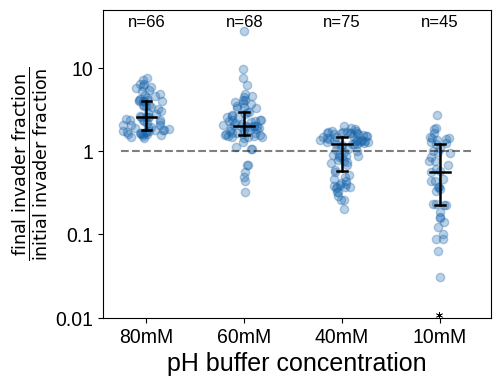

In [11]:
trm_list = copy.deepcopy(trm_list_2s) # list of treatments

fig = plt.figure(figsize=[5, 4])
plt.plot((-0.2638151404931629, 3.34011795035642), [0, 0], 'k--', linewidth=1.5, alpha=0.5)
np.random.seed(2)

saturation_thres = 0.9

for itrm in range(4):
    trm = trm_list[3 - itrm]
    
    # load interaction experiment data
    # df = pd.read_excel('SL_comp_cfu.xlsx', sheet_name=f'{trm}_exp20230903comp')
    # inirow = df.index[df.iloc[:, 0] == 'competition experiment'][0]
    # df.columns = df.loc[inirow, :]
    # df_comp = df.iloc[inirow+1:, 1:].set_index(df.iloc[inirow+1:, 0])
    # 
    df_comp = pd.read_excel('SL_comp_cfu.xlsx', sheet_name=f'{trm}_comp', skiprows=10)
    ini_mixfracs = np.array(df_comp['ini_mixfrac_Su'], dtype='float64').reshape([1, -1])
    ini_cfufracs = df_comp[[f'ini_CFUfrac_Su_rep{ii + 1}' for ii in range(3)]].to_numpy(dtype='float64').T
    fin_cfufracs = df_comp[[f'fin_CFUfrac_Su_rep{ii + 1}' for ii in range(3)]].to_numpy(dtype='float64').T
    fin_mixfracs = df_comp[[f'fin_mixfrac_Su_rep{ii + 1}' for ii in range(3)]].to_numpy(dtype='float64').T
    
    # data to plot: fold change of invader fraction, log10 scale
    data_raw = np.log10(fin_cfufracs / ini_cfufracs)
    data = copy.deepcopy(data_raw)  # scatter cannot handle nan or inf
    data[np.isnan(data)] = 0
    data[np.isinf(data)] = 0
    
    # Sample displacement value for each data point, scaled by probability density (similar to violin plot)
    kde = gaussian_kde(data[(~np.isnan(data)) * (np.nanmean(fin_cfufracs, axis=0) < saturation_thres)])
    displacement = (np.random.rand(*data.shape) * 2 - 1) * (kde(data.flatten())).reshape(*data.shape) * 0.15
    
    # scatter plot
    idx_saturate = np.where(np.nanmean(fin_cfufracs, axis=0) > saturation_thres)[0][0]  # entries before saturation of final invader fraction
    # above saturation
    # scatter1 = plt.scatter(displacement[:, idx_saturate:] + itrm, data_raw[:, idx_saturate:],
    #                        alpha=0.3, color=mpl.colormaps['Blues'](0.3), label='')
    # below saturation
    scatter2 = plt.scatter(displacement[:, :idx_saturate] + itrm, data_raw[:, :idx_saturate],
                           alpha=0.3, color=mpl.colormaps['Blues'](0.8), label='')
    # add sample size
    plt.text(itrm, 1.5, f'n={np.sum(~np.isnan(data_raw[:, :idx_saturate]))}', fontsize=12, ha='center')
    
    # median and quantiles
    plt.plot([itrm - 0.1, itrm + 0.1], [np.nanmedian(data_raw[:, :idx_saturate])] * 2, 'k-', linewidth=1.8, alpha=1)
    plt.plot([itrm, itrm], [np.nanquantile(data_raw[:, :idx_saturate], 0.25),
                            np.nanquantile(data_raw[:, :idx_saturate], 0.75)], 'k-', linewidth=1.8, alpha=1)
    plt.plot([itrm - 0.05, itrm + 0.05], [np.nanquantile(data_raw[:, :idx_saturate], 0.25)] * 2, 'k-', linewidth=1.8, alpha=1)
    plt.plot([itrm - 0.05, itrm + 0.05], [np.nanquantile(data_raw[:, :idx_saturate], 0.75)] * 2, 'k-', linewidth=1.8, alpha=1)
    
    # outlier
    plt.ylim([-2, 1.7])
    is_outlier = data_raw[:, :idx_saturate] < plt.ylim()[0]
    plt.plot(displacement[:, :idx_saturate][is_outlier] + itrm, np.ones(is_outlier.sum()) * plt.ylim()[0] + 0.01 * (plt.ylim()[1] - plt.ylim()[0]), markersize=5, color='k', 
         linestyle='', marker=(6, 2, 0), mew=0.5)

# plt.legend([scatter2, scatter1], ['> 0.9 (close to maximum)', '<= 0.9 (below maximum)'], title='Final invader fracion')    
plt.xticks(range(4), [f'{trm}' for trm in trm_list[::-1]])
plt.xlabel('pH buffer concentration')
# plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{final\ invader}}{\mathrm{initial\ invader}}\right)$')
plt.ylabel(r'$\frac{\mathrm{final\ invader\ fraction}}{\mathrm{initial\ invader\ fraction}}$')
plt.yticks([-2, -1, 0, 1], [0.01, 0.1, 1, 10])

plt.savefig('sl_resistance_sum_cutoff.svg')

### Resistance as interaction curves (Fig3b, FigS8)

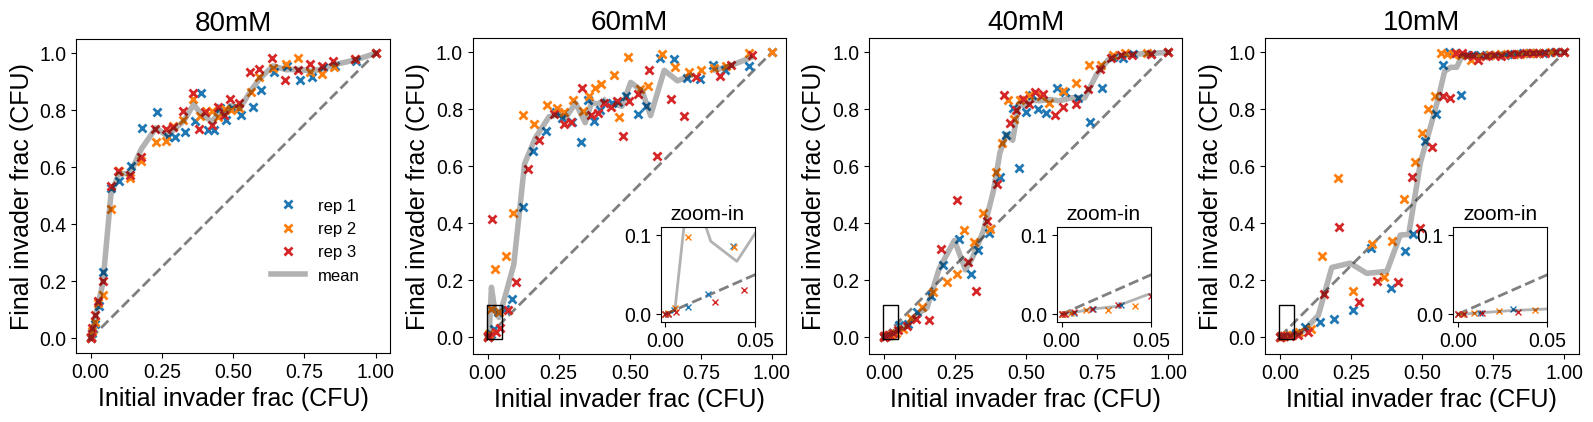

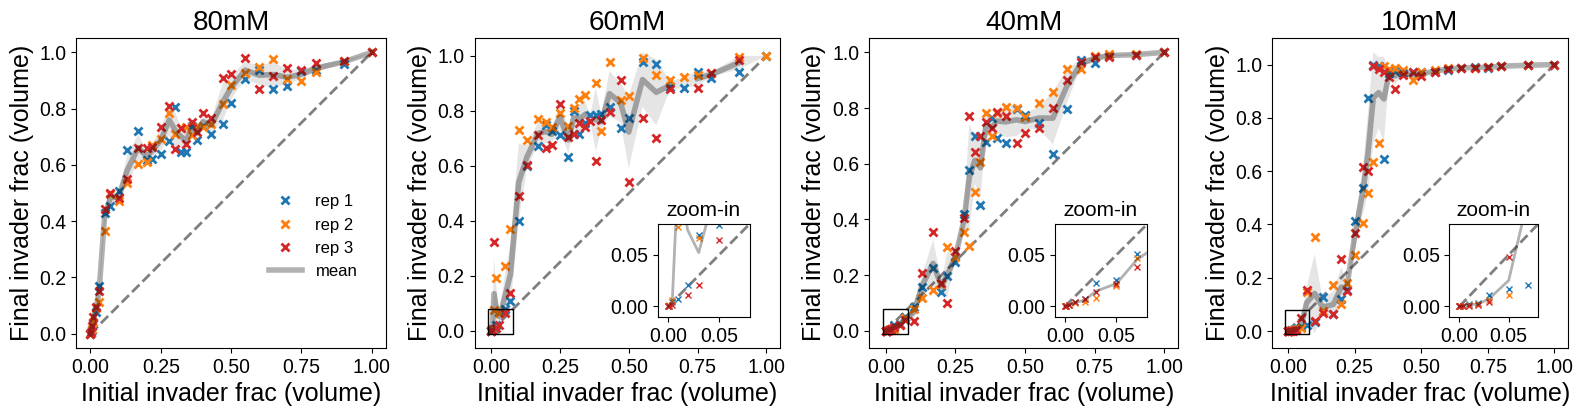

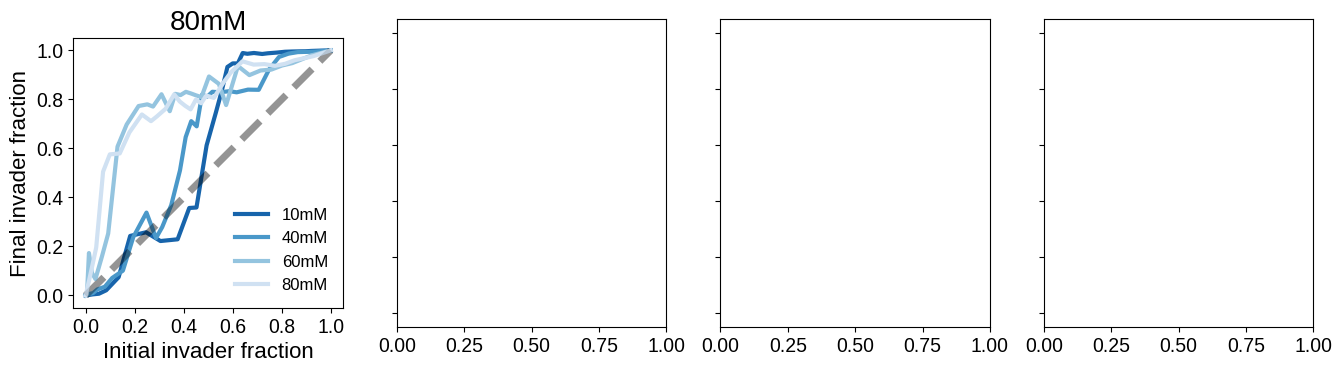

In [13]:
trm_list = copy.deepcopy(trm_list_2s)  # list of treatments
zoomin = [True, True, True, False]  # whether to zoom in the plot for each treatment

fig1, axes1 = plt.subplots(1, 4, figsize=[16, 4])
fig2, axes2 = plt.subplots(1, 4, figsize=[16, 4])
fig3, axes3 = plt.subplots(1, 4, figsize=[16, 4], sharey=True)
for itrm in range(4):
    trm = trm_list[itrm]
    df = pd.read_excel('SL_comp_cfu.xlsx', sheet_name=f'{trm}_exp20230903comp', skiprows=10)
    
    # plot frac vs. frac based on CFU
    ax1 = axes1[3 - itrm]
    plt.sca(ax1)
    ax1.set_aspect('equal', 'box')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
    ini_cfufracs = df[[f'ini_CFUfrac_Su_rep{irep + 1}' for irep in range(3)]].to_numpy().T
    fin_cfufracs = df[[f'fin_CFUfrac_Su_rep{irep + 1}' for irep in range(3)]].to_numpy().T
    for irep in range(3):
        plt.plot(ini_cfufracs[irep], fin_cfufracs[irep],
                 'x', color=mpl.colormaps['tab10']([0, 1, 3][irep]), label=f'rep {irep + 1}', lw=2, mew=2)
    plt.plot(ini_cfufracs.mean(axis=0), fin_cfufracs.mean(axis=0), 'k-', linewidth=4, alpha=0.3, label='mean')
    plt.xlabel('Initial invader frac (CFU)')
    plt.ylabel('Final invader frac (CFU)')
    plt.title(f'{trm}')
    
    # create a zoom-in axis
    if zoomin[itrm]:
        axins = ax1.inset_axes([0.6, 0.1, 0.3, 0.3])
        axins.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
        for irep in range(3):
            axins.plot(ini_cfufracs[irep], fin_cfufracs[irep],
                     'x', color=mpl.colormaps['tab10']([0, 1, 3][irep]), label=f'rep {irep + 1}', markersize=5, mew=1, lw=2)
        axins.plot(ini_cfufracs.mean(axis=0), fin_cfufracs.mean(axis=0), 'k-', linewidth=2, alpha=0.3, label='mean')
        
        zoomin_xlim = [-0.0025, 0.05]
        axins.set_xlim(zoomin_xlim)
        zoomin_ylim = [-0.01, 0.11]
        axins.set_ylim(zoomin_ylim)
        axins.set_title('zoom-in', fontsize=15)
        ax1.plot([zoomin_xlim[0], zoomin_xlim[1], zoomin_xlim[1], zoomin_xlim[0], zoomin_xlim[0]],
                 [zoomin_ylim[0], zoomin_ylim[0], zoomin_ylim[1], zoomin_ylim[1], zoomin_ylim[0]],
                 'k-', lw=1)
    
    # plot frac vs. frac based on mixing volume
    ax2 = axes2[3 - itrm]
    plt.sca(ax2)
    ax2.set_aspect('equal', 'box')
    
    ini_mixfracs = df[f'ini_mixfrac_Su']
    # ini_mixfracs = [float(istr[:-1]) for istr in ini_mixfracs]
    ini_mixfracs = np.repeat(np.array(ini_mixfracs), 3).reshape([-1, 3]).T
    fin_mixfracs = df[[f'fin_mixfrac_Su_rep{irep + 1}' for irep in range(3)]].to_numpy().T
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
    for irep in range(3):
        plt.plot(ini_mixfracs[irep], fin_mixfracs[irep],
                 'x', color=mpl.colormaps['tab10']([0, 1, 3][irep]), label=f'rep {irep + 1}', mew=2)
    plt.plot(ini_mixfracs.mean(axis=0), fin_mixfracs.mean(axis=0), 'k-', linewidth=4, alpha=0.3, label='mean')
    plt.fill_between(np.nanmean(ini_mixfracs, axis=0), 
                     np.nanmean(fin_mixfracs, axis=0) - np.nanstd(fin_mixfracs, axis=0), 
                     np.nanmean(fin_mixfracs, axis=0) + np.nanstd(fin_mixfracs, axis=0),
                     color='k', alpha=0.1, edgecolor='none')
    plt.xlabel('Initial invader frac (volume)')
    plt.ylabel('Final invader frac (volume)')
    plt.title(f'{trm}')
    
    # create a zoom-in axis
    if zoomin[itrm]:
        axins2 = ax2.inset_axes([0.6, 0.1, 0.3, 0.3])
        axins2.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
        for irep in range(3):
            axins2.plot(ini_mixfracs[irep], fin_mixfracs[irep],
                     'x', color=mpl.colormaps['tab10']([0, 1, 3][irep]), label=f'rep {irep + 1}', markersize=5, mew=1, lw=2)
        axins2.plot(ini_mixfracs.mean(axis=0), fin_mixfracs.mean(axis=0), 'k-', linewidth=2, alpha=0.3, label='mean')
        # axins2.fill_between(np.nanmean(ini_mixfracs, axis=0), 
        #                  np.nanmean(fin_mixfracs, axis=0) - np.nanstd(fin_mixfracs, axis=0), 
        #                  np.nanmean(fin_mixfracs, axis=0) + np.nanstd(fin_mixfracs, axis=0),
        #                  color='k', alpha=0.1, edgecolor='none')
        
        zoomin_xlim = [-0.01, 0.08]
        axins2.set_xlim(zoomin_xlim)
        zoomin_ylim = [-0.01, 0.08]
        axins2.set_ylim(zoomin_ylim)
        axins2.set_title('zoom-in', fontsize=15)
        ax2.plot([zoomin_xlim[0], zoomin_xlim[1], zoomin_xlim[1], zoomin_xlim[0], zoomin_xlim[0]],
                 [zoomin_ylim[0], zoomin_ylim[0], zoomin_ylim[1], zoomin_ylim[1], zoomin_ylim[0]],
                 'k-', lw=1)
    
    # simplified plot for the main figure    
    ax3 = axes3[0]
    ax3.set_aspect('equal', 'box')
    plt.sca(ax3)

    plt.xlabel('Initial invader fraction', fontsize=16)
    plt.ylabel('Final invader fraction', fontsize=16)
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax3.plot(np.nanmean(ini_cfufracs, axis=0), np.nanmean(fin_cfufracs, axis=0), 
             color=mpl.colormaps['Blues'](0.8 - itrm * 0.2), linewidth=3, label=trm)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5 / 4)
    plt.title(trm)
    plt.legend()
        
axes1[0].legend(loc=[0.6, 0.2])
axes2[0].legend(loc=[0.6, 0.2])

fig1.tight_layout()
fig2.tight_layout()
# fig1.savefig('sup_SL_comp_byCFU.svg', bbox_inches="tight")
# fig2.savefig('sup_SL_comp_byvolume.svg', bbox_inches="tight")
# fig3.savefig('SL_interaction_curve.svg')

### OD600 correlates with invader fraction (FigS3)

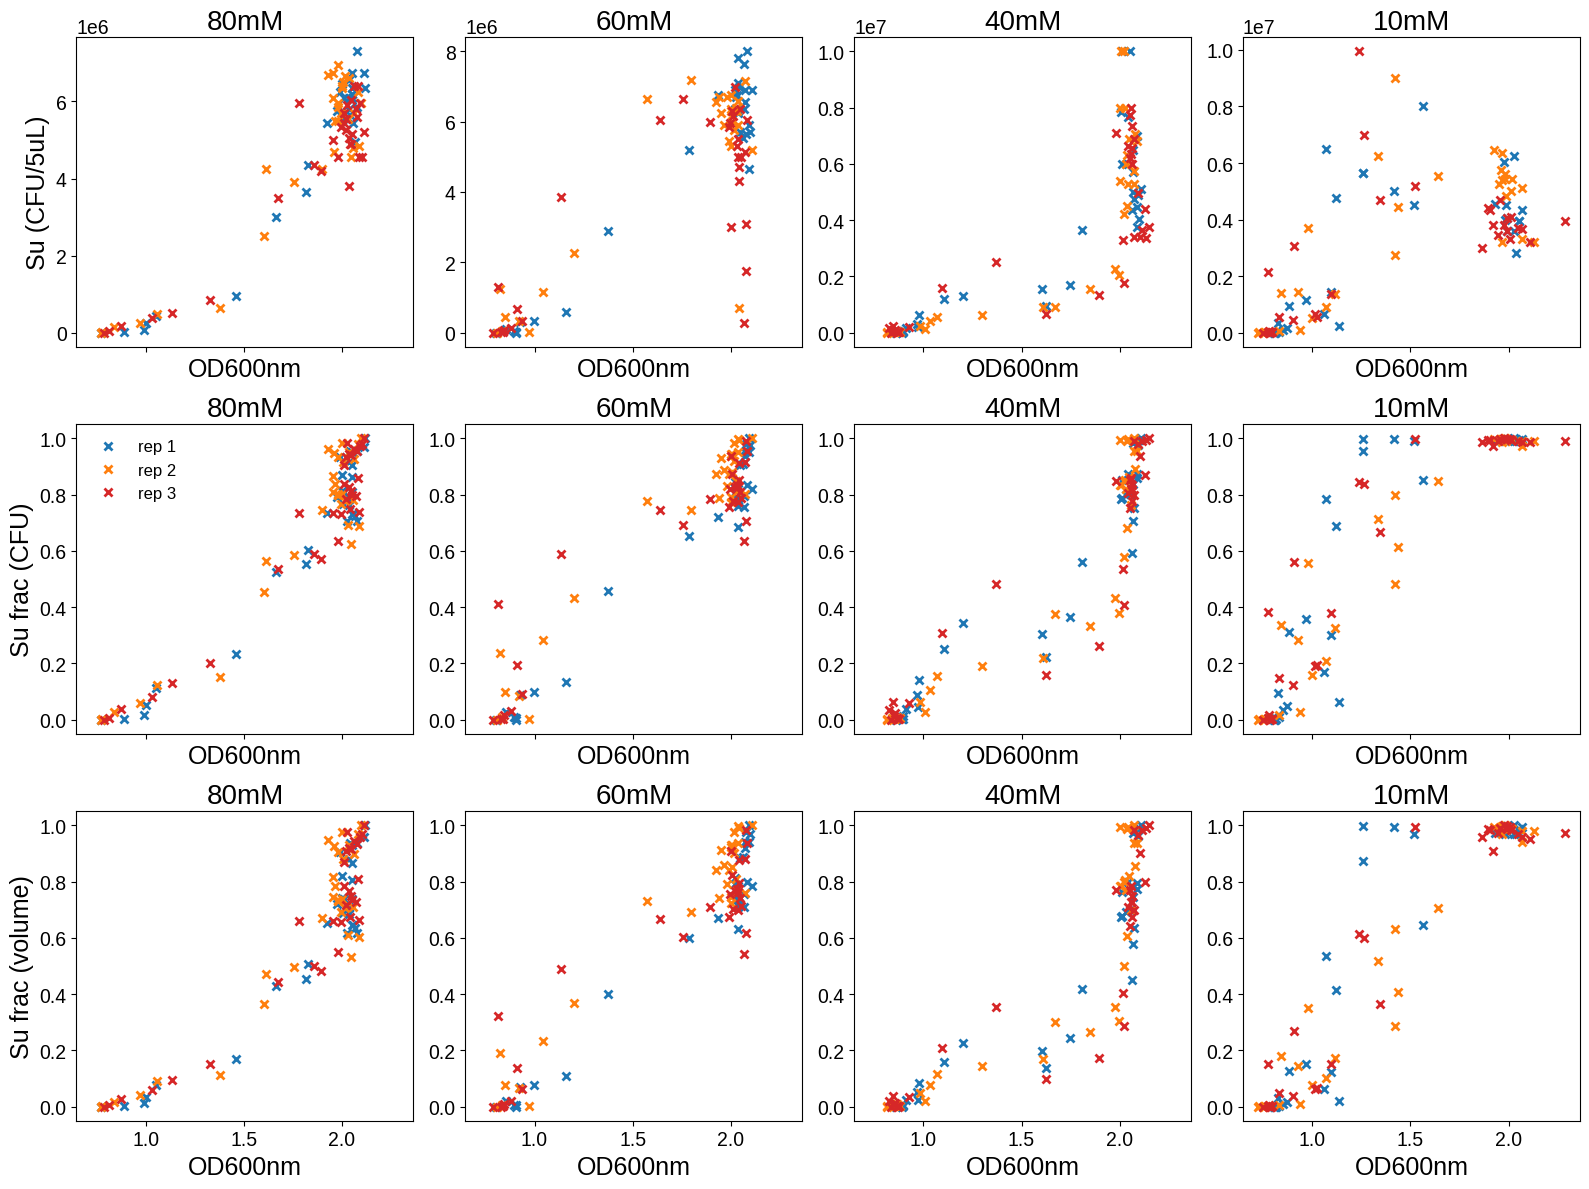

In [14]:
trm_list = copy.deepcopy(trm_list_2s) # list of treatments
fig, axes = plt.subplots(3, 4, figsize=[16, 12], sharex=True)
plot_fun = lambda x: x
for ii in range(3):
    y_names = ['CFU', 'CFUfrac', 'mixfrac']
    y_labels = ['Su (CFU/5uL)', 'Su frac (CFU)', 'Su frac (volume)']
    for itrm in range(4):
        iax = 3 - itrm
        plt.sca(axes[ii, iax])
        trm = trm_list[itrm]
        df = pd.read_excel('SL_comp_cfu.xlsx', sheet_name=f'{trm}_exp20230903comp', skiprows=10)
        y_data = df[[f'fin_{y_names[ii]}_Su_rep{irep + 1}' for irep in range(3)]].to_numpy()
        x_data = df[[f'OD600nm_rep{irep + 1}' for irep in range(3)]].to_numpy()
        for irep in range(3):
            # x_data = df[f'OD600nm_rep{irep + 1}']
            # y_data = df[f'fin_{y_names[ii]}_Su_rep{irep + 1}']
            plt.plot(plot_fun(x_data[:, irep]), plot_fun(y_data[:, irep]), 'x', color=mpl.colormaps['tab10']([0, 1, 3][irep]), mew=2, label=f'rep {irep + 1}')
        # plt.plot(np.nanmean(x_data, axis=1), np.nanmean(y_data, axis=1), 'k-', alpha=0.3)
        plt.title(trm)
        plt.xlabel('OD600nm')
        if iax == 0:
            plt.ylabel(y_labels[ii])
axes[-2, 0].legend()
fig.tight_layout()
# fig.savefig('sup_SL_ODvsCFU_comp.svg')

## Multi-strain system

### Resistance as fold change of invader fraction (Fig1d)

/tmp/ipykernel_7385/2945031201.py:33: RuntimeWarning: invalid value encountered in divide
  data_raw = np.log10(fin_cfufracs / ini_cfufracs)
/tmp/ipykernel_7385/2945031201.py:33: RuntimeWarning: invalid value encountered in divide
  data_raw = np.log10(fin_cfufracs / ini_cfufracs)
/tmp/ipykernel_7385/2945031201.py:33: RuntimeWarning: invalid value encountered in divide
  data_raw = np.log10(fin_cfufracs / ini_cfufracs)
/tmp/ipykernel_7385/2945031201.py:33: RuntimeWarning: invalid value encountered in divide
  data_raw = np.log10(fin_cfufracs / ini_cfufracs)


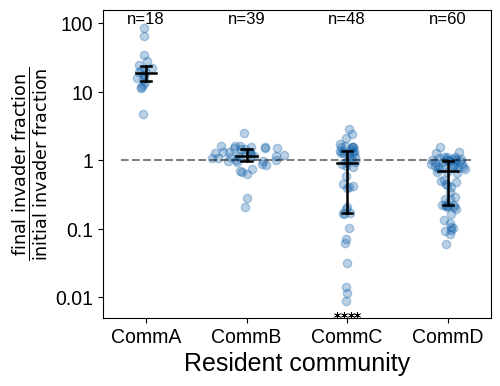

In [13]:
trm_list = copy.deepcopy(trm_list_ms) # list of treatments

# experimental wavespeed
colors = mpl.colormaps['tab10']([0, 1, 3])
    
# plotting of f(g) and experiment-like simulation (i.e. 10 days, 8 wells, 8 experimental migration rates)
nday = 11
nwell = 8
m_list_thr = np.linspace(0.01, np.sqrt(0.4), 45)**2
m_list_exp1 = np.array([0.2, 0.8, 2, 3.8, 6, 10, 20, 40]) / 100
m_list_exp2 = np.array([2, 4, 6, 8, 10, 12, 22, 40]) / 100
m_list_exp = np.concatenate([m_list_exp1.reshape([1, -1]), m_list_exp2.reshape([1, -1])], axis=0)

# fig1, axes1 = plt.subplots(1, 4, figsize=[20, 4], sharey=True)
fig = plt.figure(figsize=[5, 4])
plt.plot((-0.25, 3.25), [0, 0], 'k--', linewidth=1.5, alpha=0.5)
# sns.reset_orig()
df_foldgrowth = pd.DataFrame()
np.random.seed(2)

saturation_thres = 0.9
for itrm in range(4):
    trm = trm_list[3 - itrm]
    
    # load competition experiment (interaction curve) data
    df_comp = pd.read_excel('CM_comp_cfu.xlsx', sheet_name=f'{trm}_comp', header=0, index_col=0, nrows=25)
    ini_mix_fracs = df_comp['ini_mixfrac_Pa']
    ini_cfufracs = df_comp[[f'ini_CFUfrac_Pa_rep{ii + 1}' for ii in range(3)]].to_numpy(dtype='float64').T
    fin_cfufracs = df_comp[[f'fin_CFUfrac_Pa_rep{ii + 1}' for ii in range(3)]].to_numpy(dtype='float64').T
    fin_mixfracs = df_comp[[f'fin_mixfrac_Pa_rep{ii + 1}' for ii in range(3)]].to_numpy(dtype='float64').T
    
    # data to plot: fold change of invader fraction, log10 scale
    data_raw = np.log10(fin_cfufracs / ini_cfufracs)
    data = copy.deepcopy(data_raw)  # scatter cannot handle nan or inf
    data[np.isnan(data)] = 0
    data[np.isinf(data)] = 0
    
    # Sample displacement value for each data point, scaled by probability density (similar to violin plot)
    kde = gaussian_kde(data[(~np.isnan(data)) * (np.nanmean(fin_cfufracs, axis=0) < saturation_thres)])
    displacement = (np.random.rand(*data.shape) * 2 - 1) * (kde(data.flatten())).reshape(*data.shape) * 0.15
    
    # scatter plot
    idx_saturate = np.where(np.nanmean(fin_cfufracs, axis=0) > saturation_thres)[0][0]  # entries before saturation of final invader fraction
    # above saturation
    # scatter1 = plt.scatter(displacement[:, idx_saturate:] + itrm, data_raw[:, idx_saturate:],
    #                        alpha=0.3, color=mpl.colormaps['Blues'](0.3), label='')
    # below saturation
    scatter2 = plt.scatter(displacement[:, :idx_saturate] + itrm, data_raw[:, :idx_saturate],
                           alpha=0.3, color=mpl.colormaps['Blues'](0.8), label='')
    # add sample size
    plt.text(itrm, 2, f'n={np.sum(~np.isnan(data_raw[:, :idx_saturate]))}', fontsize=12, ha='center')
    
    # median and quantiles
    plt.plot([itrm - 0.1, itrm + 0.1], [np.nanmedian(data_raw[:, :idx_saturate])] * 2, 'k-', linewidth=1.8, alpha=1)
    plt.plot([itrm, itrm], [np.nanquantile(data_raw[:, :idx_saturate], 0.25),
                            np.nanquantile(data_raw[:, :idx_saturate], 0.75)], 'k-', linewidth=1.8, alpha=1)
    plt.plot([itrm - 0.05, itrm + 0.05], [np.nanquantile(data_raw[:, :idx_saturate], 0.25)] * 2, 'k-', linewidth=1.8, alpha=1)
    plt.plot([itrm - 0.05, itrm + 0.05], [np.nanquantile(data_raw[:, :idx_saturate], 0.75)] * 2, 'k-', linewidth=1.8, alpha=1)
    
    plt.ylim([-2.3, 2.2])
    # outlier
    is_outlier = data_raw[:, :idx_saturate] < plt.ylim()[0]
    plt.plot(np.linspace(-0.1, 0.1, is_outlier.sum()) + itrm, np.ones(is_outlier.sum()) * plt.ylim()[0] + 0.01 * (plt.ylim()[1] - plt.ylim()[0]), markersize=5, color='k', 
         linestyle='', marker=(6, 2, 0), mew=0.5)

# plt.legend([scatter2, scatter1], ['> 0.9 (close to maximum)', '<= 0.9 (below maximum)'], title='Final invader fracion')    

plt.xticks(range(4), [f'{trm}' for trm in trm_list[::-1]])
# plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{final\ invader}}{\mathrm{initial\ invader}}\right)$')
plt.xlabel('Resident community')
plt.ylabel(r'$\frac{\mathrm{final\ invader\ fraction}}{\mathrm{initial\ invader\ fraction}}$')
plt.yticks([-2, -1, 0, 1, 2], [0.01, 0.1, 1, 10, 100])

plt.savefig('cm_resistance_sum_cutoff.svg')

### Resistance as interaction curves (Fig3c, FigS9)

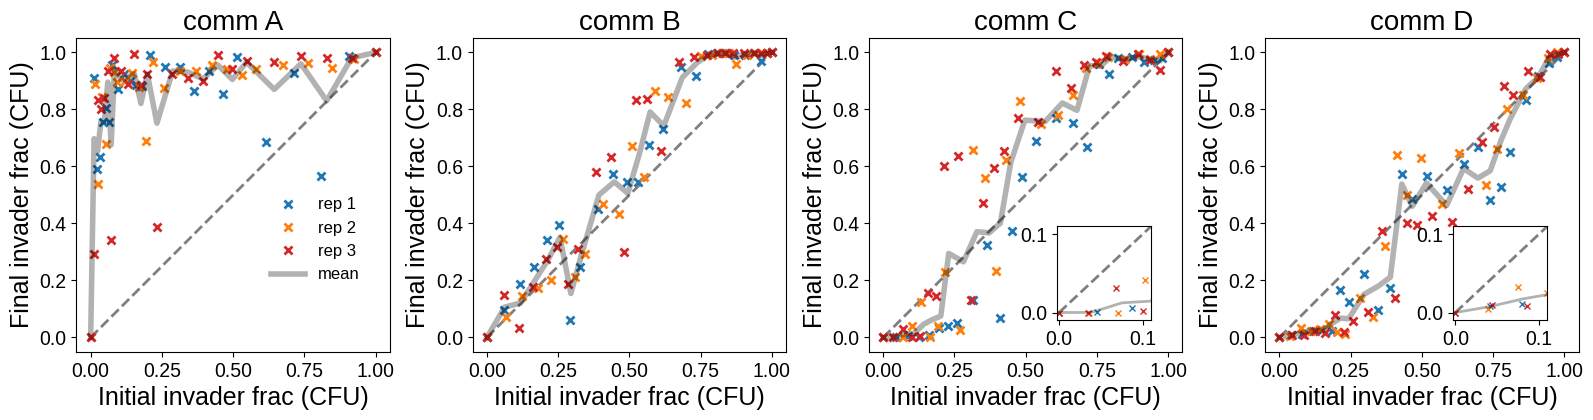

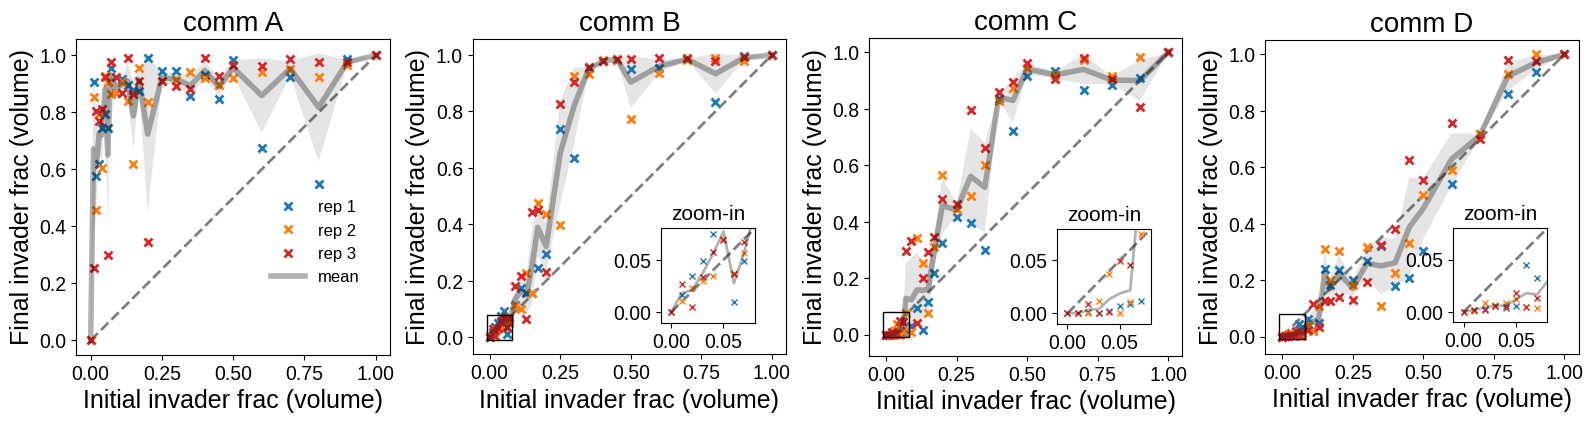

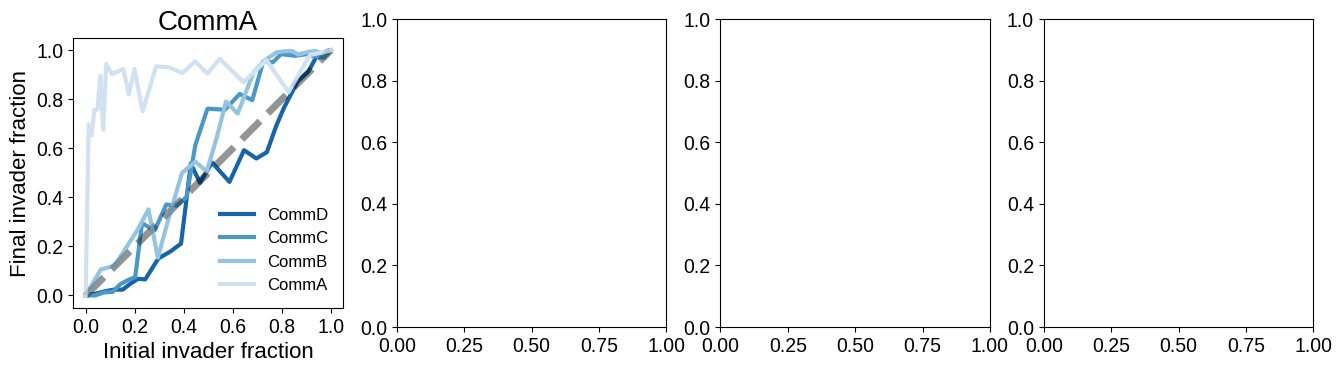

In [15]:
trm_list = copy.deepcopy(trm_list_ms)
trm_idx_dict = copy.deepcopy(trm_idx_dict_ms)

zoomin_cfu = [True, True, False, False]
zoomin_mix = [True, True, True, False]
fig1, axes1 = plt.subplots(1, 4, figsize=[16, 4])
fig2, axes2 = plt.subplots(1, 4, figsize=[16, 4])
fig3, axes3 = plt.subplots(1, 4, figsize=[16, 4])
for itrm in range(4):
    trm = trm_list[itrm]
    df = pd.read_excel('CM_comp_cfu.xlsx', sheet_name=f'{trm}_comp', header=0, nrows=25)
    
    # plot frac vs. frac based on CFU
    ax1 = axes1[3 - itrm]
    plt.sca(ax1)
    ax1.set_aspect('equal', 'box')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
    ini_cfufracs = df[[f'ini_CFUfrac_Pa_rep{irep + 1}' for irep in range(3)]].to_numpy().T
    fin_cfufracs = df[[f'fin_CFUfrac_Pa_rep{irep + 1}' for irep in range(3)]].to_numpy().T
    for irep in range(3):
        plt.plot(ini_cfufracs[irep], fin_cfufracs[irep],
                 'x', color=mpl.colormaps['tab10']([0, 1, 3][irep]), label=f'rep {irep + 1}', lw=2, mew=2)

    plt.plot(np.nanmean(ini_cfufracs, axis=0), np.nanmean(fin_cfufracs, axis=0), 'k-', linewidth=4, alpha=0.3, label='mean')
    # plt.fill_between(x_values, fill_ymin, fill_ymax, color='k', alpha=0.1, edgecolor='none')
    plt.xlabel('Initial invader frac (CFU)')
    plt.ylabel('Final invader frac (CFU)')
    plt.title(f'comm {trm_idx_dict[trm]}')
    
    # create a zoom-in axis
    if zoomin_cfu[itrm]:
        axins = ax1.inset_axes([0.6, 0.1, 0.3, 0.3])
        axins.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
        for irep in range(3):
            axins.plot(ini_cfufracs[irep], fin_cfufracs[irep],
                     'x', color=mpl.colormaps['tab10']([0, 1, 3][irep]), label=f'rep {irep + 1}', markersize=5, mew=1, lw=2)
        axins.plot(ini_cfufracs.mean(axis=0), fin_cfufracs.mean(axis=0), 'k-', linewidth=2, alpha=0.3, label='mean')
                           
        axins.set_xlim([-0.0025, 0.11])
        axins.set_ylim([-0.01, 0.11])
    
    # plot frac vs. frac based on mixing volume
    ax2 = axes2[3 - itrm]
    plt.sca(ax2)
    ax2.set_aspect('equal', 'box')
    
    ini_mixfracs = df[f'ini_mixfrac_Pa']
    # ini_mixfracs = [float(istr[:-1]) for istr in ini_mixfracs]
    ini_mixfracs = np.repeat(np.array(ini_mixfracs), 3).reshape([-1, 3]).T
    fin_mixfracs = df[[f'fin_mixfrac_Pa_rep{irep + 1}' for irep in range(3)]].to_numpy().T
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
    for irep in range(3):
        plt.plot(ini_mixfracs[irep], fin_mixfracs[irep],
                 'x', color=mpl.colormaps['tab10']([0, 1, 3][irep]), label=f'rep {irep + 1}', mew=2)
    plt.plot(np.nanmean(ini_mixfracs, axis=0), np.nanmean(fin_mixfracs, axis=0), 'k-', linewidth=4, alpha=0.3, label='mean')
    plt.fill_between(np.nanmean(ini_mixfracs, axis=0), 
                     np.nanmean(fin_mixfracs, axis=0) - np.nanstd(fin_mixfracs, axis=0), 
                     np.nanmean(fin_mixfracs, axis=0) + np.nanstd(fin_mixfracs, axis=0),
                     color='k', alpha=0.1, edgecolor='none')
    plt.xlabel('Initial invader frac (volume)')
    plt.ylabel('Final invader frac (volume)')
    plt.title(f'comm {trm_idx_dict[trm]}')
    
    # create a zoom-in axis
    if zoomin_mix[itrm]:
        axins2 = ax2.inset_axes([0.6, 0.1, 0.3, 0.3])
        axins2.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
        for irep in range(3):
            axins2.plot(ini_mixfracs[irep], fin_mixfracs[irep],
                     'x', color=mpl.colormaps['tab10']([0, 1, 3][irep]), label=f'rep {irep + 1}', markersize=5, mew=1, lw=2)
        axins2.plot(ini_mixfracs.mean(axis=0), fin_mixfracs.mean(axis=0), 'k-', linewidth=2, alpha=0.3, label='mean')
        # axins2.fill_between(np.nanmean(ini_mixfracs, axis=0), 
        #                  np.nanmean(fin_mixfracs, axis=0) - np.nanstd(fin_mixfracs, axis=0), 
        #                  np.nanmean(fin_mixfracs, axis=0) + np.nanstd(fin_mixfracs, axis=0),
        #                  color='k', alpha=0.1, edgecolor='none')
        
        zoomin_xlim = [-0.01, 0.08]
        axins2.set_xlim(zoomin_xlim)
        zoomin_ylim = [-0.01, 0.08]
        axins2.set_ylim(zoomin_ylim)
        axins2.set_title('zoom-in', fontsize=15)
        ax2.plot([zoomin_xlim[0], zoomin_xlim[1], zoomin_xlim[1], zoomin_xlim[0], zoomin_xlim[0]],
                 [zoomin_ylim[0], zoomin_ylim[0], zoomin_ylim[1], zoomin_ylim[1], zoomin_ylim[0]],
                 'k-', lw=1)
    
    # simplified plot for the main figure    
    ax3 = axes3[0]
    ax3.set_aspect('equal', 'box')
    plt.sca(ax3)

    plt.xlabel('Initial invader fraction', fontsize=16)
    plt.ylabel('Final invader fraction', fontsize=16)
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax3.plot(np.nanmean(ini_cfufracs, axis=0), np.nanmean(fin_cfufracs, axis=0), 
             color=mpl.colormaps['Blues'](0.8 - itrm * 0.2), linewidth=3, label=trm)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5 / 4)
    plt.title(trm)
    plt.legend()
    
axes1[0].legend(loc=[0.6, 0.2])
axes2[0].legend(loc=[0.6, 0.2])

fig1.tight_layout()
fig2.tight_layout()
# fig1.savefig(f'{fig_path}sup_CM_comp_byCFU.svg', bbox_inches="tight")
# fig2.savefig(f'{fig_path}sup_CM_comp_byvolume.svg', bbox_inches="tight")

### luminescence signal correlates with invader fraction (FigS4)

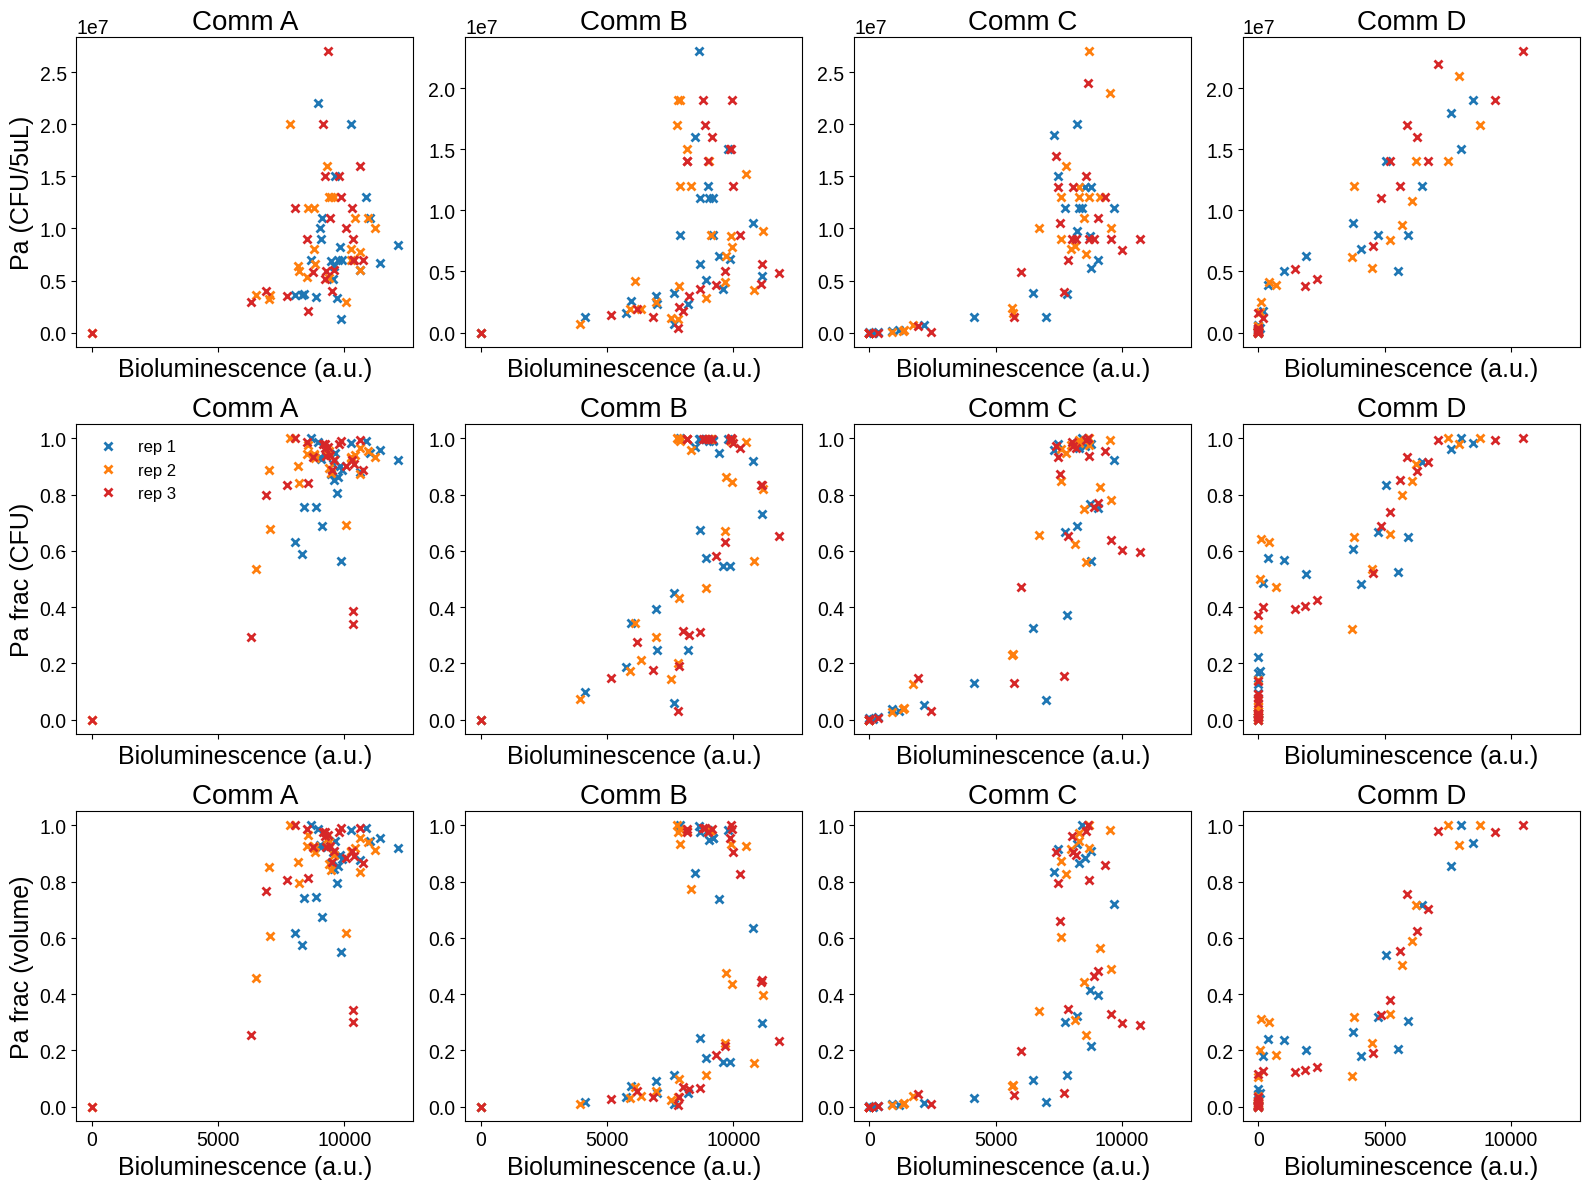

In [12]:
trm_list = copy.deepcopy(trm_list_ms)
trm_idx_dict = copy.deepcopy(trm_idx_dict_ms)

fig, axes = plt.subplots(3, 4, figsize=[16, 12], sharex=True)
plot_fun = lambda x: x
for ii in range(3):
    y_names = ['CFU', 'CFUfrac', 'mixfrac']
    y_labels = ['Pa (CFU/5uL)', 'Pa frac (CFU)', 'Pa frac (volume)']
    for itrm in range(4):
        plt.sca(axes[ii, 3 - itrm])
        trm = trm_list_ms[itrm]
        df = pd.read_excel('CM_comp_cfu.xlsx', sheet_name=f'{trm}_comp', header=0, nrows=25)
        y_data = df[[f'fin_{y_names[ii]}_Pa_rep{irep + 1}' for irep in range(3)]].to_numpy()
        x_data = df[[f'luminescence_rep{irep + 1}' for irep in range(3)]].to_numpy()
        for irep in range(3):
            plt.plot(plot_fun(x_data[:, irep]), plot_fun(y_data[:, irep]), 'x', color=mpl.colormaps['tab10']([0, 1, 3][irep]), mew=2, label=f'rep {irep + 1}')

        plt.title(f'Comm {trm_idx_dict[trm]}')
        plt.xlabel('Bioluminescence (a.u.)')
        if itrm == 3:
            plt.ylabel(y_labels[ii])

axes[-2,0].legend(['rep 1', 'rep 2', 'rep 3'])
fig.tight_layout()
fig.savefig(f'{fig_path}sup_CM_ODvsCFU_comp.svg')

# Fig - Prediction framework

## Two-strain system

### Predicted invasion speed vs. observed invasion speed (Fig3b)

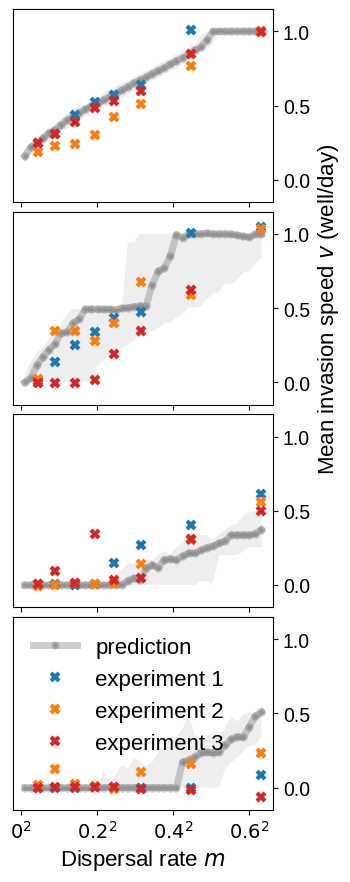

In [42]:
# experimental wavespeed
trm_list = copy.deepcopy(trm_list_2s)
ws_exp_dict = copy.deepcopy(ws_exp_dict_2s)
interact_dict_2s = dict.fromkeys(ws_exp_dict.keys())  # interaction curve for each experiment
colors = mpl.colormaps['tab10']([0, 1, 3])
    
# plotting of f(g) and experiment-like simulation (i.e. 10 days, 8 wells, 8 experimental migration rates)
nday = 11
nwell = 8
m_list_thr = np.linspace(0.01, np.sqrt(0.4), 40)**2

fig3, axes3 = plt.subplots(4, 1, figsize=[4.2 * 0.8, 13 * 0.8], sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05)
for itrm in range(4)[::-1]:
    trm = trm_list[itrm]
    
    # load competition experiment (interaction curve) data
    df = pd.read_excel('SL_comp_cfu.xlsx', sheet_name=f'{trm}_exp20230903comp', header=None)
    inirow = df.index[df.iloc[:, 0] == 'competition experiment'][0]
    df.columns = df.loc[inirow, :]
    df_comp = df.iloc[inirow+1:, 1:].set_index(df.iloc[inirow+1:, 0])
    ini_mix_fracs = df_comp['ini_mixfrac_Su']
    ini_fracs = df_comp[[f'ini_CFUfrac_Su_rep{ii + 1}' for ii in range(3)]].to_numpy(dtype='float64').T
    fin_fracs = df_comp[[f'fin_CFUfrac_Su_rep{ii + 1}' for ii in range(3)]].to_numpy(dtype='float64').T
    fin_mix_fracs = df_comp[[f'fin_mixfrac_Su_rep{ii + 1}' for ii in range(3)]].to_numpy(dtype='float64').T
    
    # fit interaction curve g(f) from the interaction experiment data, with standard deviation
    # calculate the wave speed from the interaction curve
    funcs_with_std = {}
    wave_speeds_with_std = {}
    for func_key in ['mean', 'upper', 'lower']:
        add_std = {'mean':0, 'upper':1, 'lower':-1}[func_key]  # add different standard deviation to mean
        func_xvalues = ini_mix_fracs
        func_yvalues = np.nanmean(fin_mix_fracs, axis=0) + add_std * np.nanstd(fin_mix_fracs, axis=0)
        func_yvalues[func_yvalues < 0] = 0
        func_yvalues[func_yvalues > 1] = 1
        funcs_with_std[func_key] = interp1d(func_xvalues, func_yvalues)
        wave_speeds_with_std[func_key] = np.nanmean(calc_inv_speed(sim_waves(funcs_with_std[func_key], m_list_thr), f_thre=0.5)[:, 5:], axis=1)
    # store the interaction curves
    interact_dict_2s[trm] = copy.deepcopy(funcs_with_std)
    
    # plot v vs. \sqrt(m) theory
    plt.sca(axes3[3 - itrm])
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")

    plt.xlabel('Dispersal rate $m$', fontsize=16)
    if itrm == 2:
        plt.ylabel('Mean invasion speed $v$ (well/day)', fontsize=16)
    if itrm == 0:
        plt.xticks([0, 0.2, 0.4, 0.6], [f"${sq_m}^2$" for sq_m in [0, 0.2, 0.4, 0.6]])
    plt.yticks(np.linspace(0, 1, 3))

    # Plotting the mean curve
    plt.plot(np.sqrt(m_list_thr), wave_speeds_with_std['mean'], '.-', color=mpl.colormaps['Greys'](0.7), alpha=0.3, label='prediction')
    # Filling the space between upper and lower curves
    plt.fill_between(np.sqrt(m_list_thr), wave_speeds_with_std['upper'], wave_speeds_with_std['lower'], 
                     color=mpl.colormaps['Greys'](0.7), alpha=0.1, edgecolor='none')

    plt.ylim([-0.15, 1.15])
    
    # plot v vs. \sqrt(m) exp
    for irep in range(3):
        m_list_exp = copy.deepcopy(m_list_dict_2s[rep_list_dict_2s[trm][irep]])
        wave_speeds_instantaneous = ws_exp_dict[trm][irep, :]
        wave_speeds = np.array([ws_i[~np.isnan(ws_i)][3:].mean() for ws_i in wave_speeds_instantaneous])
        plt.plot(np.sqrt(m_list_exp), wave_speeds, 'x', label='experiment {}'.format(irep+1), color=colors[irep], lw=5)
    # plt.plot(np.sqrt(m_list_exp), np.nanmean(ws_exp_dict[trm], axis=0), 'kx-', label='exp mean', alpha=0.5)
    
    # plt.title(trm)
    
    if itrm == 0:
        plt.legend(fontsize=16)
# plt.tight_layout()
fig3.subplots_adjust(wspace=0.1)
# fig3.savefig('SL_pred.svg')

### Predicted phase diagram (Fig3b)

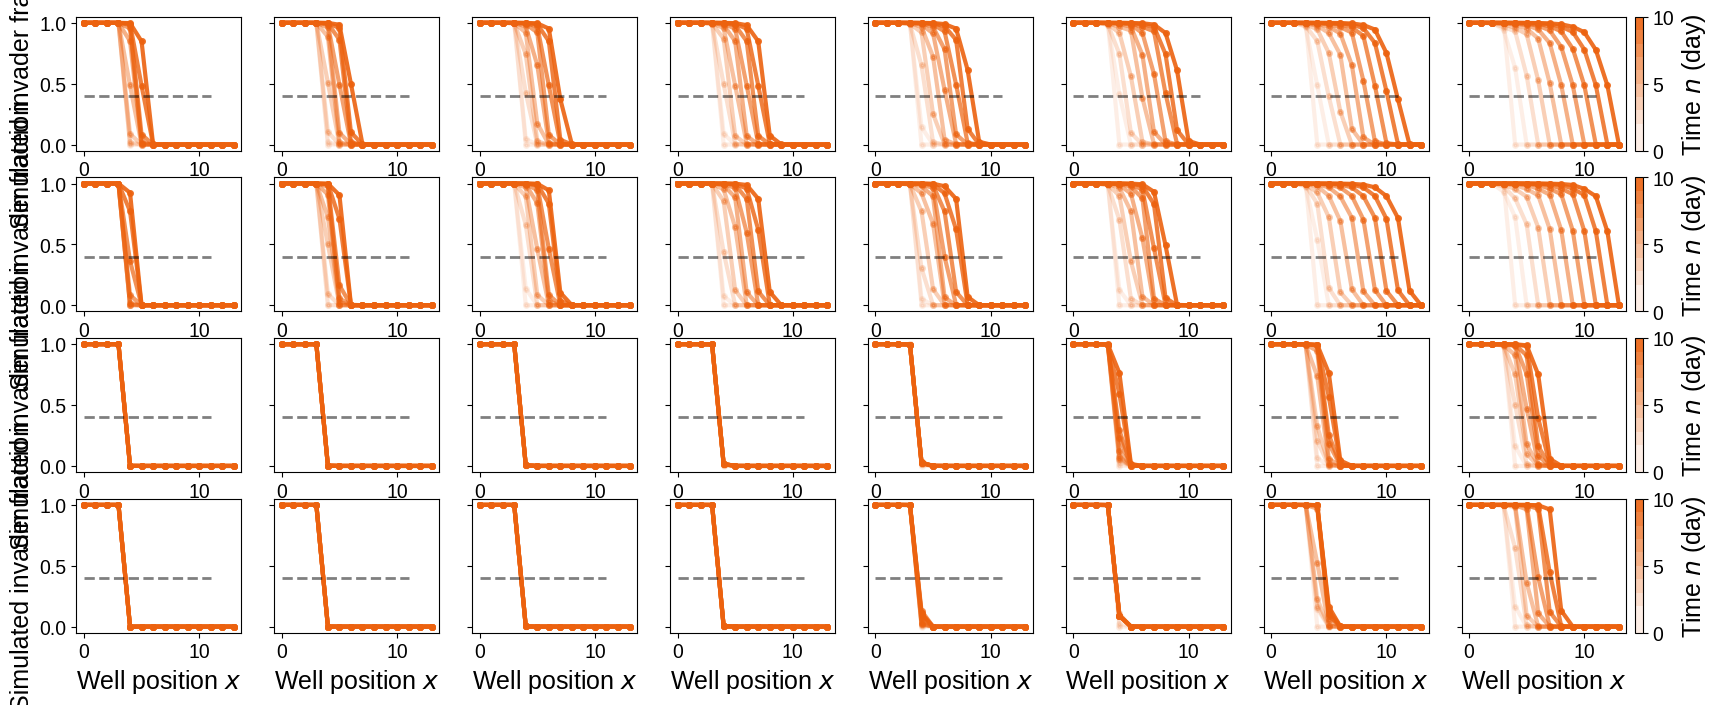

In [28]:
# plotting of f(g) and experiment-like simulation (i.e. 10 days, 8 wells, 8 experimental migration rates)
nday = 10
nwells = [4, 10]
irep = 0
trm_list = copy.deepcopy(trm_list_2s)
m_list = copy.deepcopy(m_list_dict_2s[rep_list_dict_2s[trm_list[0]][irep]])

fig, axes = plt.subplots(4, 8, figsize=[20, 8], sharey=True)
for itrm in range(4):
    trm = trm_list[itrm]
    iax = 3 - itrm

    func = interact_dict_2s[trm]['mean']
    series_allm = sim_waves(func, m_list, nday, nwells)
    for im in range(len(m_list)):
        plt.sca(axes[iax, im])
        if False: #irep == 0 and im in [0, 1, 3]:
            pass
        else:
            # data = np.squeeze(luc_arr_normed_dict[trm][irep][:, im, :])
            data = series_allm[im]
            draw_wave(data, fig=fig, cbar=(im == 7))
            plt.plot([0, 11], [0.4, 0.4], 'k--', lw=2, alpha=0.5)
        if im == 0:
            plt.ylabel('Simulated invader fraction')
        else:
            plt.ylabel('')

(-0.5, 1.5)

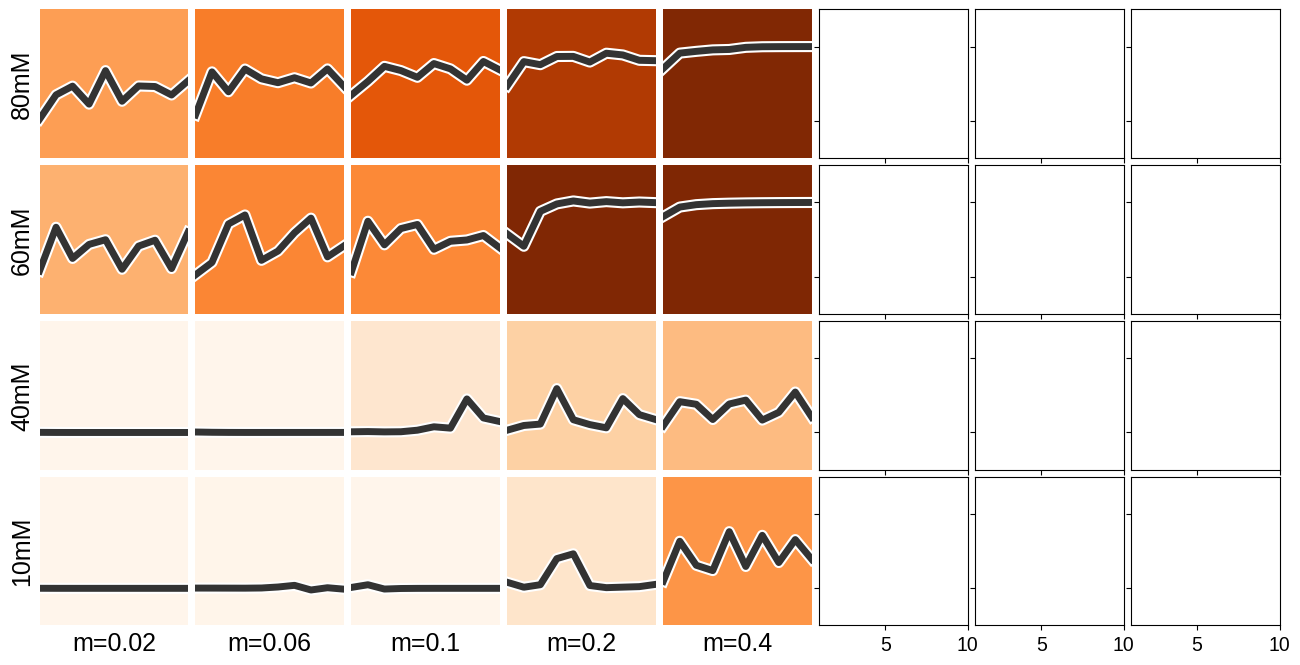

In [48]:
# phase diagram of predicted invasion dynamics
trm_list = copy.deepcopy(trm_list_2s)

nday = 11
nwells = [4, 16]
m_list = copy.deepcopy(m_list_dict_2s[rep_list_dict_2s[trm_list[0]][irep]])

data = np.zeros((4, 8, nday - 1))  # 4 trm * 8 m * n day.
data[:, :, :] = np.nan

for itrm in range(4):
    trm = trm_list[itrm]

    func = interact_dict_2s[trm]['mean']
    data[3 - itrm, :, :] = calc_inv_speed(sim_waves(func, m_list, nday, nwells), f_thre=0.5)[:, 1:]
    
time_points = np.arange(1, data.shape[-1] + 1)

# Calculate the mean for each time series
means = np.nanmean(data[:, :, 2:], axis=2)

fig, axs = plt.subplots(4, 8, figsize=(16, 8), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Define color scaling based on the mean values
vmax = np.nanmax(means)
vmin = np.nanmin(means)
cmap = plt.cm.Oranges

# Define line color and path effects for the time series
linecolor = [0.2, 0.2, 0.2]
strokecolor = 'white'

for i in range(4):
    for j in range(5):
        im = [2, 4, 5, 6, 7][j]  # plot only the selected dispersal rates
        # im = j
        
        # Set background color based on the mean value
        normalized_mean = (means[i, im] - vmin) / (vmax - vmin)
        facecolor = cmap(normalized_mean)
        axs[i, j].set_facecolor(facecolor)

        # Plot the time series directly
        axs[i, j].plot(time_points, data[i, im],
                       color=linecolor,
                       path_effects=[pe.Stroke(linewidth=8, foreground=strokecolor), pe.Normal()])

        # Hide axis spines, ticks, and tick labels
        axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        for spine in axs[i, j].spines.values():
            spine.set_visible(False)

        # Add custom axis labels
        if i == 3:  # For the bottom-most row
            axs[i, j].set_xlabel(f"m={m_list[im]}")
        if j == 0:  # For the left-most column
            axs[i, j].set_ylabel(f"{trm_list[3 - i]}")

plt.xlim([1, data.shape[-1]])
plt.ylim([-0.5, 1.5])
# fig.savefig('sl_phasediagram.svg')


## Multi-strain system

### Predicted invasion speed vs. observed invasion speed (Fig3c)

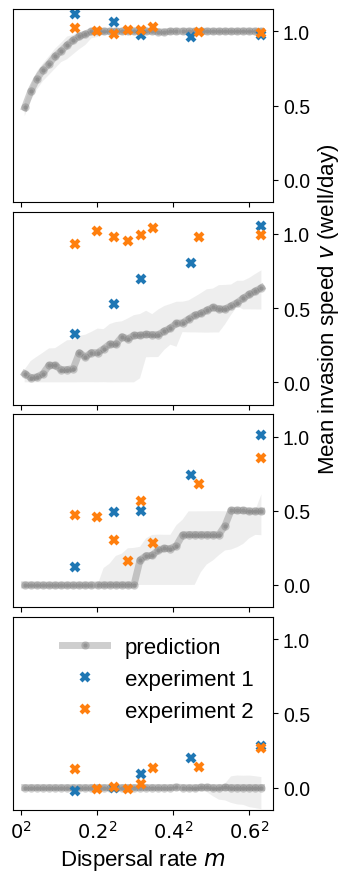

In [18]:
# experimental wavespeed
trm_list = copy.deepcopy(trm_list_ms)
ws_exp_dict = copy.deepcopy(ws_exp_dict_ms)
interact_dict_ms = dict.fromkeys(ws_exp_dict.keys())  # interaction curve for each experiment
colors = mpl.colormaps['tab10']([0, 1, 3])
    
# plotting of f(g) and experiment-like simulation (i.e. 10 days, 8 wells, 8 experimental migration rates)
nday = 11
nwell = 8
m_list_thr = np.linspace(0.01, np.sqrt(0.4), 40)**2

fig3, axes3 = plt.subplots(4, 1, figsize=[4.2 * 0.8, 13 * 0.8], sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05)
for itrm in range(4)[::-1]:
    trm = trm_list[itrm]
    
    # load competition experiment (interaction curve) data
    df = pd.read_excel('CM_comp_cfu.xlsx', sheet_name=f'{trm}_comp', header=0, nrows=25, index_col=0)
    ini_mix_fracs = np.array(df_comp['ini_mixfrac_Pa'], dtype='float64')
    ini_cfu_fracs = df_comp[[f'ini_CFUfrac_Pa_rep{ii + 1}' for ii in range(3)]].to_numpy(dtype='float64').T
    fin_cfu_fracs = df_comp[[f'fin_CFUfrac_Pa_rep{ii + 1}' for ii in range(3)]].to_numpy(dtype='float64').T
    fin_mix_fracs = df_comp[[f'fin_mixfrac_Pa_rep{ii + 1}' for ii in range(3)]].to_numpy(dtype='float64').T
    
    # fit interaction curve g(f) from the interaction experiment data, with standard deviation
    # calculate the wave speed from the interaction curve
    funcs_with_std = {}
    wave_speeds_with_std = {}
    for func_key in ['mean', 'upper', 'lower']:
        add_std = {'mean':0, 'upper':1, 'lower':-1}[func_key]  # add different standard deviation to mean
        func_xvalues = ini_mix_fracs
        func_yvalues = np.nanmean(fin_mix_fracs, axis=0) + add_std * np.nanstd(fin_mix_fracs, axis=0)
        func_yvalues[func_yvalues < 0] = 0
        func_yvalues[func_yvalues > 1] = 1
        funcs_with_std[func_key] = interp1d(func_xvalues, func_yvalues)
        wave_speeds_with_std[func_key] = np.nanmean(calc_inv_speed(sim_waves(funcs_with_std[func_key], m_list_thr), f_thre=0.5)[:, 5:], axis=1)
    # store the interaction curves
    interact_dict_ms[trm] = copy.deepcopy(funcs_with_std)
    
    # plot v vs. \sqrt(m) theory
    plt.sca(axes3[3 - itrm])
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")

    plt.xlabel('Dispersal rate $m$', fontsize=16)
    if itrm == 2:
        plt.ylabel('Mean invasion speed $v$ (well/day)', fontsize=16)
    if itrm == 0:
        plt.xticks([0, 0.2, 0.4, 0.6], [f"${sq_m}^2$" for sq_m in [0, 0.2, 0.4, 0.6]])
    plt.yticks(np.linspace(0, 1, 3))

    # Plotting the mean curve
    plt.plot(np.sqrt(m_list_thr), wave_speeds_with_std['mean'], '.-', color=mpl.colormaps['Greys'](0.7), alpha=0.3, label='prediction')
    # Filling the space between upper and lower curves
    plt.fill_between(np.sqrt(m_list_thr), wave_speeds_with_std['upper'], wave_speeds_with_std['lower'], 
                     color=mpl.colormaps['Greys'](0.7), alpha=0.1, edgecolor='none')

    plt.ylim([-0.15, 1.15])
    
    # plot v vs. \sqrt(m) exp
    for irep in range(2):
        m_list_exp = copy.deepcopy(m_list_dict_ms[rep_list_dict_ms[trm][irep]])
        wave_speeds_instantaneous = ws_exp_dict[trm][irep, :]
        wave_speeds = np.array([ws_i[~np.isnan(ws_i)][3:].mean() for ws_i in wave_speeds_instantaneous])
        if irep == 0:  # two dispersal rates with 1/100x source plate are not comparable to rest
            wave_speeds[[0, 1, 3]] = np.nan
        plt.plot(np.sqrt(m_list_exp), wave_speeds, 'x', label='experiment {}'.format(irep+1), color=colors[irep], lw=5)
    # plt.plot(np.sqrt(m_list_exp), np.nanmean(ws_exp_dict[trm], axis=0), 'kx-', label='exp mean', alpha=0.5)
    
    # plt.title(trm)
    
    if itrm == 0:
        plt.legend(fontsize=16)
# plt.tight_layout()
fig3.subplots_adjust(wspace=0.1)
fig3.savefig(f'{fig_path}CM_pred.svg')

### Predicted phase diagram (Fig3c)

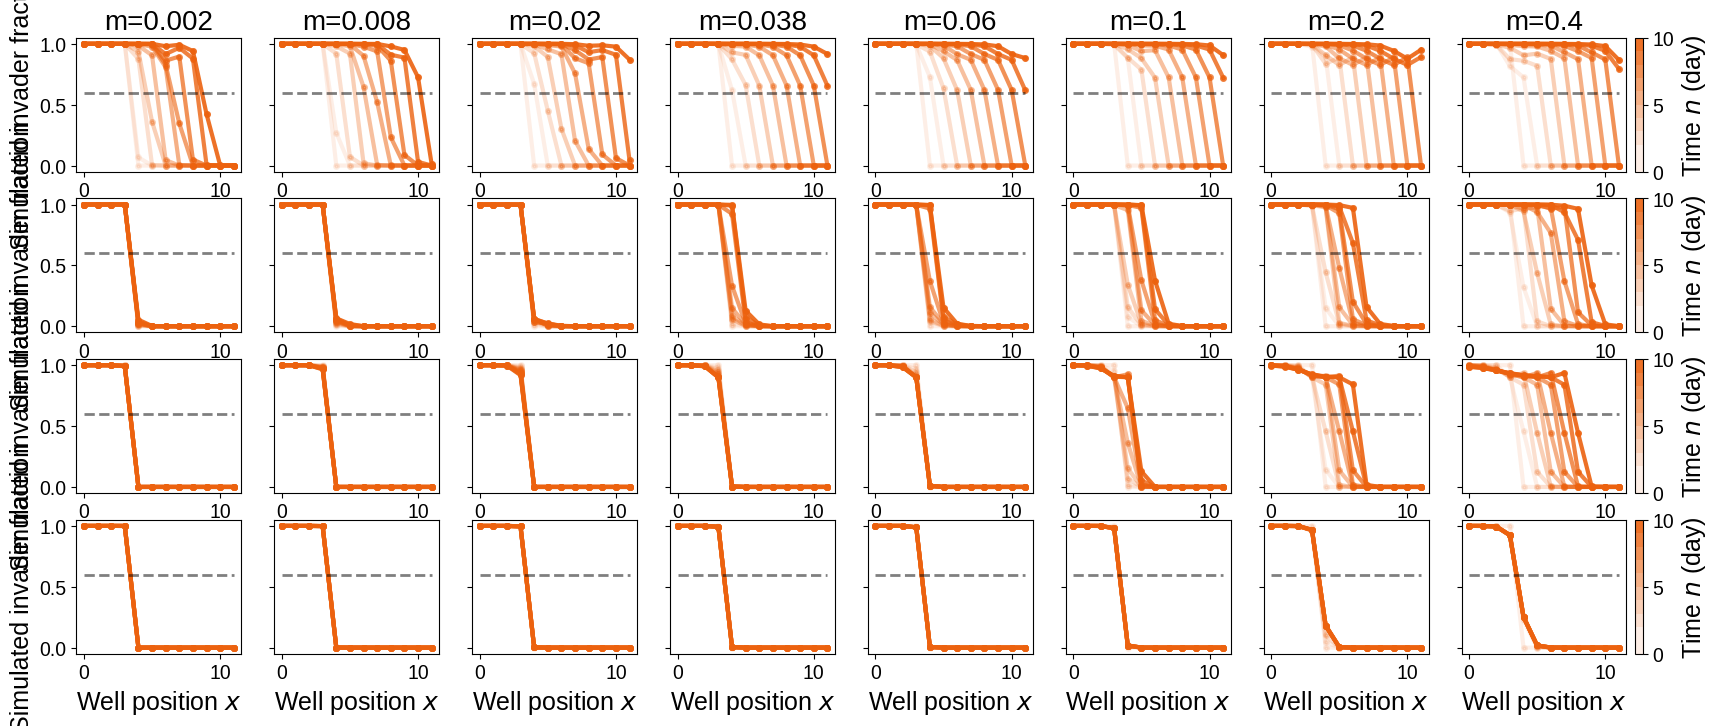

In [45]:
trm_list = copy.deepcopy(trm_list_ms)
   
# plotting of f(g) and experiment-like simulation (i.e. 10 days, 8 wells, 8 experimental migration rates)
nday = 10
nwells = [4, 8]
irep = 0
m_list_thr = np.linspace(0.01, np.sqrt(0.4), 40)**2
m_list = copy.deepcopy(m_list_dict_ms[rep_list_dict_ms[trm_list[0]][irep]])

fig, axes = plt.subplots(4, 8, figsize=[20, 8], sharey=True)
for itrm in range(4):
    trm = trm_list[itrm]
    iax = 3 - itrm

    func = interact_dict_ms[trm]['mean']
    series_allm = sim_waves(func, m_list, nday, nwells)
    for im in range(len(m_list)):
        plt.sca(axes[iax, im])

        # data = np.squeeze(luc_arr_normed_dict[trm][irep][:, im, :])
        data = series_allm[im]
        draw_wave(data, fig=fig, cbar=(im == 7))
        plt.plot([0, 11], [0.6, 0.6], 'k--', lw=2, alpha=0.5)
        if im == 0:
            plt.ylabel('Simulated invader fraction')
        else:
            plt.ylabel('')
        if iax == 0:
            plt.title(f"m={m_list[im]}")
# fig3.savefig('CM_pred.svg')

(-0.5, 1.5)

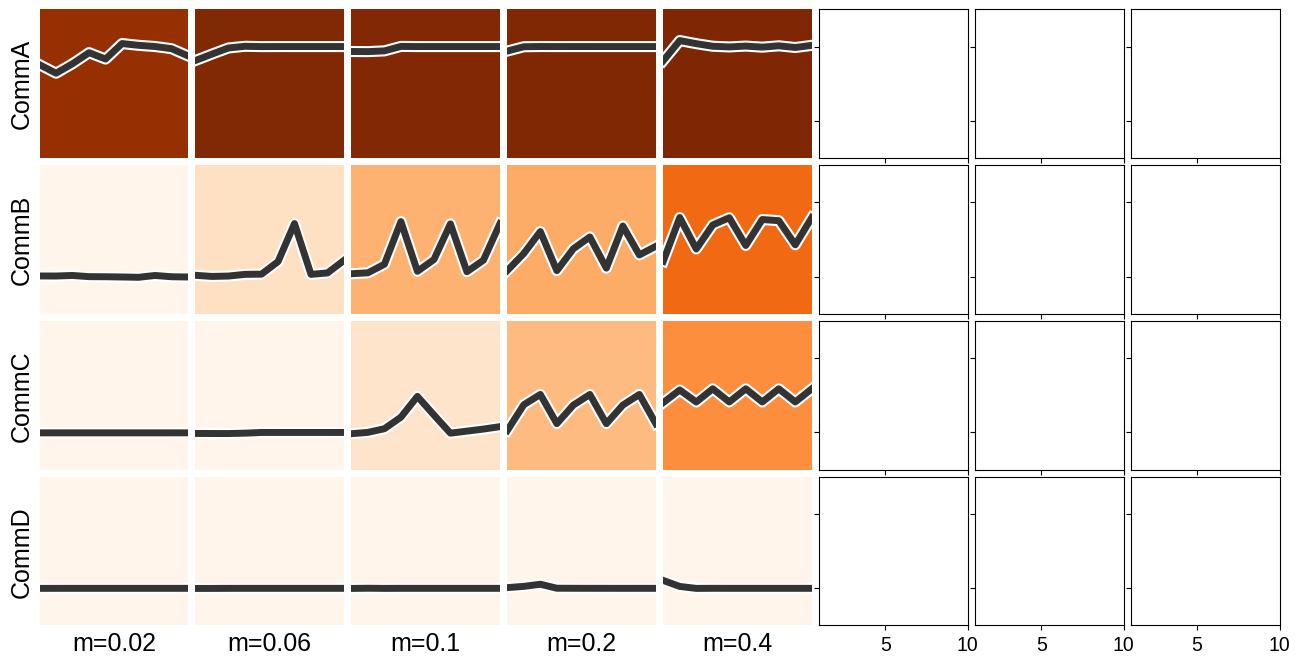

In [46]:
# phase diagram of predicted invasion dynamics
trm_list = copy.deepcopy(trm_list_ms)[::-1]

nday = 11
nwells = [4, 16]
m_list = copy.deepcopy(m_list_dict_ms[rep_list_dict_ms[trm_list[0]][irep]])

data = np.zeros((4, 8, nday - 1))  # 4 trm * 8 m * n day.
data[:, :, :] = np.nan

for itrm in range(4):
    trm = trm_list[itrm]

    func = interact_dict_ms[trm]['mean']
    # data[itrm, :, :] = calc_inv_speed(sim_waves(func, m_list, nday, nwells), f_thre=0.5)[:, 1:]
    data[itrm, :, :] = calc_inv_speed(sim_waves(func, m_list, nday), f_thre=0.5)[:, 1:]
    
time_points = np.arange(1, data.shape[-1] + 1)

# Calculate the mean for each time series
means = np.nanmean(data[:, :, 2:], axis=2)

fig, axs = plt.subplots(4, 8, figsize=(16, 8), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Define color scaling based on the mean values
vmax = np.nanmax(means)
vmin = np.nanmin(means)
vmin = 0
cmap = plt.cm.Oranges

# Define line color and path effects for the time series
linecolor = [0.2, 0.2, 0.2]
strokecolor = 'white'

for i in range(4):
    for j in range(5):
        im = [2, 4, 5, 6, 7][j]
        # im = j
        # Set background color based on the mean value
        normalized_mean = (means[i, im] - vmin) / (vmax - vmin)
        facecolor = cmap(normalized_mean)
        axs[i, j].set_facecolor(facecolor)

        # Plot the time series directly
        axs[i, j].plot(time_points, data[i, im],
                       color=linecolor,
                       path_effects=[pe.Stroke(linewidth=8, foreground=strokecolor), pe.Normal()])

        # Hide axis spines, ticks, and tick labels
        axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        for spine in axs[i, j].spines.values():
            spine.set_visible(False)

        # Add custom axis labels
        if i == 3:  # For the bottom-most row
            axs[i, j].set_xlabel(f"m={m_list[im]}")
        if j == 0:  # For the left-most column
            axs[i, j].set_ylabel(f"{trm_list[i]}")

plt.xlim([1, data.shape[-1]])
plt.ylim([-0.5, 1.5])
# fig.savefig('cm_phasediagram_pred.svg')